# How To Make a Hit Movie

Project for [Applied Data Analysis 2018](https://dlab.epfl.ch/teaching/fall2018/cs401/)

Team members: ZHOU Xiao, LIU Jiafan

**Abstract**: Today, movies are basically the most popular type of art and entertainment for us. People go to the cinema to watch a movie or buy it on Amazon, and give reviews and ratings on it. But for movie makers, movies are a type of business. Some blockbusters like "Avatar" have earned billions of dollars, while a lot of other movies are not as lucky as the highest-grossing ones. So we may wonder how to make a hit movie. We will try to use data analysis to answer this question. From the matadata, reviews, ratings and even subtitles of movies, we would like to find factors and features that make a movie to become best seller on Amazon or take high revenues from the box office.

**Dataset**: For the project, the datasets we analyse are as follows:

- [Amazon reviews dataset](http://jmcauley.ucsd.edu/data/amazon/index.html) contains totally 142.8 million product reviews (ratings, text, votes) and related metadata from Amazon. Among the huge data, we mainly use the 'Movies and TV' part for the inplementation of our ideas.

- [TMDB movie dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata) is a dataset we find on Kaggle. It contains metadata on thousands of movies, including the plot, cast, crew, budget, vote, revenues, etc.

# Contents

**Milestone 1** (See [README](https://github.com/catJeff/ada-movie-analysis) on Github)]

[**Milestone 2**](#Milestone-2)
- [1. Data Loading and Preprocessing](#1.-Data-Loading-and-Preprocessing)
 - [1.1) Amazon Data Loading and Preprocessing](#1.1%29--Amazon-Data-Loading-and-Preprocessing)
 - [1.2) TMDB Data Loading and Preprocessing](#1.2%29-TMDB-Data-Loading-and-Preprocessing)
 - [1.3) Merging Amazon Data and TMDB Data](#1.3%29-Merging-Amazon-Data-and-TMDB-Data)
- [2. Amazon Descriptive Statistical Analysis](#2.-Amazon-Descriptive-Statistical-Analysis)
 - [2.1) Analysis on Metadata](#2.1%29-Analysis-on-Metadata)
 - [2.2) Analysis on Ratings](#2.2%29-Analysis-on-Ratings)
- [3. TMDB Descriptive Statistical Analysis](#3.-TMDB-Descriptive-Statistical-Analysis)
 - [3.1) TMDB Movie Genre Evoluation](#3.1%29-TMDB-Movie-Genre-Evoluation)
 - [3.2) Geographic Distribution](#3.2%29-Geographic-Distribution)
 - [3.3) Language and Company Distribution](#3.3%29-Language-and-Company-Distribution)
 - [3.4) Influence of Celebrity](#3.4%29-Influence-of-Celebrity)
 - [3.5) Simple Keywords Analysis](#3.5%29-Simple-Keywords-Analysis)

[**Milestone 3**](#Milestone-3)
- [3. TMDB Descriptive Statistical Analysis(Cont.)](#3.-TMDB-Descriptive-Statistical-Analysis%28Cont.%29)
 - [3.6) Profit Regression Analysis by Machine Learning](#3.6%29-Profit-Regression-Analysis-by-Machine-Learning)
- [4. How to Make a Hit Movie](#4.-How-to-Make-a-Hit-Movie)
 - [4.1) Non-numeric Data Analysis](#4.1%29-Non-numeric-Data-Analysis)
 - [4.2) Numeric Data Analysis](#4.2%29-Numeric-Data-Analysis)
 - [4.3) Review Text Analysis](#4.3%29-Review-Text-Analysis)
 - [4.4) Rating Regression Analysis by Machine Learning](#4.4%29-Rating-Regression-Analysis-by-Machine-Learning)
 

**Data Story** (See our [Github Page](https://howtomakeahitmovie.github.io/))

### Research questions
- What is the trend and evolution of movie ratings according to Amazon and TMDB?
 - We analyzed the evolution of genres and prodution countries in Section [3.1](#3.1%29-TMDB-Movie-Genre-Evoluation) and [3.2](#3.2%29-Geographic-Distribution). Besides, we analyzed a movie's rating trend on Amazon in Section [2.2](#2.2%29-Analysis-on-Ratings).
- What is the correlation between TMDB vote and Amazon reviews?
 - This question is answered by correlation analysis in Section [4.2](#4.2%29-Numeric-Data-Analysis).
- Do good reviews and ratings lead to high revenues?
 - Also see Section [4.2](#4.2%29-Numeric-Data-Analysis).
- What are the factors and features that affect the ratings and sales of movies?
 - We solved this problem by machine learning approches. See Section [3.6](#3.6%29-Profit-Regression-Analysis-by-Machine-Learning) for a regression on movie profit and Section [4](#4.-How-to-Make-a-Hit-Movie) where we did analysis on both numeric and non-numeric data(including texts) and built a machien learning model for a regression on movie rating. These give us answers on how to make a hit movie.
 
In addition to these research questions, we've also done a lot of intersting exploration and analysis on the datasets.

<h1><i><font color=blue>Milestone 2</font></i></h1>

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy as sp
import json
import requests
import warnings
sns.set_context('notebook')
warnings.filterwarnings('ignore')
import gzip
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#plotly.tools.set_credentials_file(username='', api_key='')
from wordcloud import WordCloud
import nltk
import spacy

# 1. Data Loading and Preprocessing

# 1.1)  Amazon Data Loading and Preprocessing

In this notebook, we use three data files from [Amazon review dataset](http://jmcauley.ucsd.edu/data/amazon/links.html): `meta_Movies_and_TV.json.gz`, `ratings_Movies_and_TV.csv` and `reviews_Movies_and_TV_5.json.gz`, which contain 5-core subsets of the Amazon reviews and ratings on `Movies & TV` category, and also the metadata of all `Movies & TV` products.

 | dataset | size | contents |
 | ------- | ---- | -------- |
 |`meta_Movies_and_TV.json.gz`|95.2MB (258MB after decompression)|asin, title, price, imUrl, related, salesRank, brand, categories|
 |`ratings_Movies_and_TV.csv`|178MB|reviewerID, asin, overall, unixReviewTime|
 |`reviews_Movies_and_TV_5.json.gz`| 676MB (1.84GB after decompression)| reviewerID, asin, reviewerName, helpful, reviewText, overall, summary, unixReviewTime, reviewTime|



First we define the functions to read json datasets. The datasets are not in strict json but we can use `eval()` to parse it and load it into pandas dataframes.

In [2]:
# functions to parse and read json.gz datasets

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

### Load reviews dataset to dataframes

In [4]:
# load reviews
reviews_raw = getDF('data/reviews_Movies_and_TV_5.json.gz')
reviews_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


### Load matedata to dataframes

First we import the datasets and then we do some cleaning and exploration.

In [5]:
# load metadata
meta_raw = getDF('data/meta_Movies_and_TV.json.gz')
meta_raw.head()

,asin,categories,description,title,price,salesRank,imUrl,related,brand
0,0000143561,"[[Movies & TV, Movies]]","3Pack DVD set - Italian Classics, Parties and ...","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},http://g-ecx.images-amazon.com/images/G/01/x-s...,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '...",NaN
1,0000589012,"[[Movies & TV, Movies]]",NaN,Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},http://ecx.images-amazon.com/images/I/519%2B1k...,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",NaN
2,0000695009,"[[Movies & TV, Movies]]",NaN,Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,NaN
3,000107461X,"[[Movies & TV, Movies]]",NaN,Live in Houston [VHS],NaN,{'Movies & TV': 954116},http://ecx.images-amazon.com/images/I/41WY47gL...,NaN,NaN
4,0000143529,"[[Movies & TV, Movies]]",Disc 1: Flour Power (Scones; Shortcakes; South...,My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},http://ecx.images-amazon.com/images/I/51QY79CD...,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '...",NaN


### Remove useless and redundant information

We can drop some columns which we don't need. We don't need 'description', 'imUrl' and 'brand'.

In [12]:
# remove redundant data
metadata = meta_raw.drop(['description','imUrl', 'brand'], axis=1)
metadata.head()

,asin,categories,title,price,salesRank,related
0,0000143561,"[[Movies & TV, Movies]]","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
1,0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
2,0000695009,"[[Movies & TV, Movies]]",Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},NaN
3,000107461X,"[[Movies & TV, Movies]]",Live in Houston [VHS],NaN,{'Movies & TV': 954116},NaN
4,0000143529,"[[Movies & TV, Movies]]",My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


In [26]:
# check the categories
metadata['categories'].value_counts().head()

[[Movies & TV, Movies]]                                                                  138383
[[Movies & TV, TV]]                                                                       53327
[[Movies & TV]]                                                                            1251
[[CDs & Vinyl, Classical], [CDs & Vinyl, Opera & Classical Vocal], [Movies & TV, TV]]       767
[[CDs & Vinyl, Classical], [Movies & TV, TV]]                                               630
Name: categories, dtype: int64

Since we only want to analyse the movie entries, we extract only the items with `categories` which contains 'Movies' rather than 'TV'.

In [50]:
# check if the lists in categories contain 'Movie'
def check_movie(categories):
    for lst in categories:
        if 'Movies' in lst:
            return True
    return False

non_movie_idx = []
for idx, categories in enumerate(metadata['categories']):
    if not check_movie(categories):
        non_movie_idx.append(idx)

In [53]:
# drop non-movie rows
metadata = metadata.drop(metadata.index[non_movie_idx])
metadata['categories'].value_counts().head()

[[Movies & TV, Movies]]                                                                                                         138383
[[Movies & TV, Movies], [Movies & TV, TV]]                                                                                         582
[[Movies & TV, Movies], [Pet Supplies, Dogs, Training & Behavior Aids]]                                                             25
[[Movies & TV, Movies], [Musical Instruments, Studio Recording Equipment, Mastering Recorders, DVD Recorders & Duplicators]]        22
[[Movies & TV, Movies], [Musical Instruments, Instrument Accessories, General Accessories]]                                         19
Name: categories, dtype: int64

In [54]:
metadata.shape

(139209, 6)

Up to now we get 139209 entries of movies.

We set the row indices to be the movie id `asin`, so that we can find a movie by `asin` in an easier way.

In [60]:
# set proper indices
metadata = metadata.set_index(['asin'])

In [61]:
metadata.head()

,categories,title,price,salesRank,related
asin,,,,,
0000143561,"[[Movies & TV, Movies]]","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
0000695009,"[[Movies & TV, Movies]]",Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},NaN
000107461X,"[[Movies & TV, Movies]]",Live in Houston [VHS],NaN,{'Movies & TV': 954116},NaN
0000143529,"[[Movies & TV, Movies]]",My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


### Check the NaN values

In [55]:
# check if there are NaNs
metadata.count()

asin          139209
categories    139209
title          72426
price          97614
salesRank     137063
related        98799
dtype: int64

In [56]:
metadata['title'].isna().sum()

66783

In [57]:
metadata['price'].isna().sum()

41595

In [58]:
metadata['salesRank'].isna().sum()

2146

In [59]:
metadata['related'].isna().sum()

40410

We find that the data is not that clean. All the columns besides `asin` and `categories` have NaN values. We should take care of the NaNs in the following analysis.

Since `salesRank` is an important feature for our future analysis, we would like to drop NaN values in `salesRank`. Besides, we find that not all `salesRank` are in `Movies & TV` category. After these cleanings, we transform the dictionary format in `salesRank` to be integers.

In [19]:
# remove NaN in salesRank
metadata = metadata[pd.notnull(metadata['salesRank'])]

### Clean non-movie sales rank

We find those entries whose salesRank is not in 'Movies' category.

In [21]:
# find ranks that are not in 'Movies' categery
non_movie_rank_idx = []

for idx, entry in enumerate(metadata['salesRank']):
    try:
        entry['Movies & TV']
    except:
        print(entry)
        non_movie_rank_idx.append(idx)

{'Books': 3777257}
{'Sports &amp; Outdoors': 196802}
{'Sports &amp; Outdoors': 313153}
{'Sports &amp; Outdoors': 270719}
{'Sports &amp; Outdoors': 88095}
{'Sports &amp; Outdoors': 48980}
{'Home &amp; Kitchen': 1875215}
{'Sports &amp; Outdoors': 161238}
{'Sports &amp; Outdoors': 187816}
{'Sports &amp; Outdoors': 198792}
{'Sports &amp; Outdoors': 279376}
{'Sports &amp; Outdoors': 139174}
{'Sports &amp; Outdoors': 22081}
{'Sports &amp; Outdoors': 74027}
{'Sports &amp; Outdoors': 159306}
{'Home &amp; Kitchen': 500388}
{'Sports &amp; Outdoors': 172992}
{'Sports &amp; Outdoors': 2368645}
{'Sports &amp; Outdoors': 93635}
{'Sports &amp; Outdoors': 284007}
{'Books': 12403985}
{'Sports &amp; Outdoors': 86344}
{'Sports &amp; Outdoors': 1137788}
{'Sports &amp; Outdoors': 98032}
{'Sports &amp; Outdoors': 205446}
{'Sports &amp; Outdoors': 75059}
{'Books': 4643699}
{'Sports &amp; Outdoors': 113644}
{'Sports &amp; Outdoors': 1103171}
{'Sports &amp; Outdoors': 133101}
{'Sports &amp; Outdoors': 94600}
{

In [24]:
# remove useless ranks and change the rank dictionary into integers
metadata = metadata.drop(metadata.index[non_movie_rank_idx])
metadata['salesRank'] = metadata['salesRank'].apply(lambda entry: entry['Movies & TV'])
metadata.head()

,categories,title,price,salesRank,related
asin,,,,,
0000143561,"[[Movies & TV, Movies]]","Everyday Italian (with Giada de Laurentiis), V...",12.99,376041,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
0000589012,"[[Movies & TV, Movies]]",Why Don't They Just Quit? DVD Roundtable Discu...,15.95,1084845,"{'also_bought': ['B000Z3N1HQ', '0578045427', '..."
0000695009,"[[Movies & TV, Movies]]",Understanding Seizures and Epilepsy DVD,NaN,1022732,NaN
000107461X,"[[Movies & TV, Movies]]",Live in Houston [VHS],NaN,954116,NaN
0000143529,"[[Movies & TV, Movies]]",My Fair Pastry (Good Eats Vol. 9),19.99,463562,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '..."


In [45]:
metadata.shape

(136999, 5)

Thousands of useless data has been removed.

### Import ratings data

Now we begin to deal with the ratings data. The ratings data is a subset of reviews data, while it doesn't contain review texts thus has a smaller size. So it is easier for we to first analyze only the ratings.

In [58]:
# import ratings, set column names
ratings = pd.read_csv('ratings_Movies_and_TV.csv', header=None)
ratings = ratings.rename(columns = {0:'reviewerID', 1:'asin', 2:'overall', 3:'unixReviewTime'})
ratings.head()

,reviewerID,asin,overall,unixReviewTime
0,A3R5OBKS7OM2IR,0000143502,5.0,1358380800
1,A3R5OBKS7OM2IR,0000143529,5.0,1380672000
2,AH3QC2PC1VTGP,0000143561,2.0,1216252800
3,A3LKP6WPMP9UKX,0000143588,5.0,1236902400
4,AVIY68KEPQ5ZD,0000143588,5.0,1232236800


### Check NaN values

First we check if there are NaN values in the ratings data.

In [59]:
ratings.shape

(4607047, 4)

In [60]:
# check NaNs
ratings.count()

reviewerID        4607047
asin              4607047
overall           4607047
unixReviewTime    4607047
dtype: int64

So we get the good news. Now we transform the unix timestamp 'unixReviewTime' to readable datetime format.

### Transform time format

In [62]:
# transform unix review time to data time
ratings['unixReviewTime'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings = ratings.rename(columns={'unixReviewTime': 'time'})
ratings.head()

,reviewerID,asin,overall,time
0,A3R5OBKS7OM2IR,0000143502,5.0,2013-01-17
1,A3R5OBKS7OM2IR,0000143529,5.0,2013-10-02
2,AH3QC2PC1VTGP,0000143561,2.0,2008-07-17
3,A3LKP6WPMP9UKX,0000143588,5.0,2009-03-13
4,AVIY68KEPQ5ZD,0000143588,5.0,2009-01-18


### Clean non-movie ratings

Again, we don't want useless ratings for TV. We drop the non-movie entries, i.e. those don't appear in our metadata.

In [63]:
# find non-movie ratings
non_movie_idx = []
for idx, asin in enumerate(ratings['asin']):
    if not asin in metadata.index:
        non_movie_idx.append(idx)

In [65]:
# clean non-movie ratings
ratings = ratings.drop(ratings.index[non_movie_idx])
ratings.shape

(3061065, 4)

So over 1 million useless ratings have been removed.

In [43]:
ratings['overall'].value_counts()

5.0    1699346
4.0     615578
3.0     310711
1.0     259068
2.0     176362
Name: overall, dtype: int64

We can find that the fequency of ratings are actually like 5>4>3>1>2.

# 1.2) TMDB Data Loading and Preprocessing

Load the TMDB credits data and TMDB movies data into pandas dataframes.

In [6]:
tmdb_credits_raw= pd.read_csv('data/tmdb_5000_credits.csv')
tmdb_movies_raw=pd.read_csv('data/tmdb_5000_movies.csv')

show the TMDB credits dataframe

In [7]:
tmdb_credits_raw.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


We can see the columns contained in credits dataframe, and the special index for a single film is movie_id. It contains cast and crew information.

Also, we show the dataframe of TMDB movies

In [8]:
tmdb_movies_raw.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


The dataframe also has a id column, corresponding to movie_id in previous one, and we can see there are many more information, which can process further analysis.

We merge the 2 dataframes and correspond each movie in one dataframe to the other, since they both have id features. After that,we show the columns of merged dataframe.

In [9]:
tmdb_credits_raw = tmdb_credits_raw.rename(columns= {'movie_id': 'id'})
tmdb_data_raw = pd.merge(tmdb_credits_raw, tmdb_movies_raw,on='id')
tmdb_data_raw.columns

Index(['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')

We can see the features that the dataframe contains and we can implement data analysis upon that.

In [10]:
tmdb_data = tmdb_data_raw.rename(columns= {'title_x': 'title'})

First, we can see that in some columns, the information is contained in an unnormal structure, like json. Our first step is to recognise the columns and split the data structure to distill only the useful information.

In [11]:
import json
tmdb_json_columns = ['spoken_languages','genres', 'keywords', 'production_companies', 'production_countries', 'cast','crew']
for column in tmdb_json_columns:
    tmdb_data[column] = tmdb_data[column].apply(json.loads)
def splitName(column):
    temp_col = [[temp_row['name'] for temp_row in rows] for rows in column]
    return temp_col
tmdb_split_columns = ['spoken_languages','genres', 'keywords', 'production_companies', 'production_countries', 'cast']
for column in tmdb_split_columns:
    tmdb_data[column] = splitName(tmdb_data[column])

Now we can see the columns have been turned into a list, as we show in the preprocessed preocution_countries column. It will help us a lot in further data analysis.

In [12]:
tmdb_data['production_countries'].head()

0    [United States of America, United Kingdom]
1                    [United States of America]
2    [United Kingdom, United States of America]
3                    [United States of America]
4                    [United States of America]
Name: production_countries, dtype: object

There is an exception, the crew column. There are plenty of jobs and plenty of information of that, so we can not just use use the method above to get only the names. We shall also correspond the name to their jobs.

In order to get the specific job in a crew feature, we define the function below to get the name from the specific job.

In [14]:
def getName(temp_row,job):
    temp_name=''
    for i in range(len(temp_row)):
        if temp_row[i]['job'] == job:
            temp_name = temp_row[i]['name']
            break 
    return temp_name

Here we get the name of main director and append it to the dataframe. It will help us to get the job information of a movie and it's much more convenient to implement analysis.

In [15]:
tmdb_data['director'] = [getName(temp_row,'Director') for temp_row in tmdb_data['crew']]
tmdb_data[['director']].head()

,director
0,James Cameron
1,Gore Verbinski
2,Sam Mendes
3,Christopher Nolan
4,Andrew Stanton


Also, we only take the year information of release_date.

In [16]:
tmdb_data['release_year'] = pd.to_datetime(tmdb_data['release_date']).dt.year
tmdb_data['release_year'].describe()

count    4802.000000
mean     2002.468763
std        12.414354
min      1916.000000
25%      1999.000000
50%      2005.000000
75%      2011.000000
max      2017.000000
Name: release_year, dtype: float64

Our topic is about how to make a hit movie, the goal of which is to explore how to make a movie as profitable as possible. 

In [17]:
tmdb_data['profit'] = (tmdb_data['revenue'] - tmdb_data['budget']) / tmdb_data['budget']
tmdb_data[['profit']].head()

,profit
0,10.763566
1,2.203333
2,2.594590
3,3.339756
4,0.092843


We can manually create a feature that judges whether the title of a movie has channged or not, determined by original_title and titile.

In [18]:
if_title_change= tmdb_data['original_title']==tmdb_data['title']
def judge_change(not_change):
    change=0
    if not_change: change=1
    return change
tmdb_data['title_change']= [judge_change(not_change) for not_change in if_title_change]

Also among the cast, we have to get the main actors or actresses since there are too many cast in one movie. The huge amount of vice actors and actresses will not bring a huge influence to a movie. So we only get the top 5 cast in a movie, which represents for the top main characters in a movie.

In [19]:
tmdb_data['cast']=[temp_cast[:5] for temp_cast in tmdb_data['cast']]

Now we show the columns after preprocessin of dataframe.

In [20]:
tmdb_data.columns

Index(['id', 'title', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count', 'director',
       'release_year', 'profit', 'title_change'],
      dtype='object')

To implement our topic and approach,we will use corresponding features to analyze what features make a hit movie. We manually drop the columns that will not take a casual effect of a hit movie and clean the dataframe.

In [21]:
temp_drop_col=['crew','original_title','overview','id','homepage','status','tagline','title_y','release_date']
tmdb_data = tmdb_data.drop(temp_drop_col, axis=1)

Here we finish doing simple data wrangling and the preprocessed TMDB dataframe is what we want for future analysis.

In [22]:
tmdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 18 columns):
title                   4803 non-null object
cast                    4803 non-null object
budget                  4803 non-null int64
genres                  4803 non-null object
keywords                4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
director                4803 non-null object
release_year            4802 non-null float64
profit                  3913 non-null float64
title_change            4803 non-null int64
dtypes: float64(5), int64(4), object(9)
memory usage: 712.9+ KB


# 1.3) Merging Amazon Data and TMDB Data

Above we finish the sepeate prepreocessing of amazon data and TMDB data. Our final goal is to use the all informative features to analyze how to make a hit movie. In this section, we merge the data for further deep analysis, which will be implemented until Milestone 3.

In [29]:
merge_raw=pd.merge(tmdb_data, metadata,on='title')
merge_raw=pd.merge(merge_raw, reviews_raw,on='asin')
merge_raw.head()

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,price,related,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A2JJ0KQTN8QED3,Bap8494,"[4, 4]",I can't understand why I haven't heard more ab...,5.0,Shocking!!,1332115200,"03 19, 2012"
1,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A35Z5BLHL9CI8P,"Charlene ""divercity@interia.pl""","[2, 4]","It's definitely a must-see. Very climatic, mys...",5.0,"Great acting, great plot, great movie",1125360000,"08 30, 2005"
2,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A19RAJY6R7USN0,"Lee Neville ""emotionboy""","[4, 6]",Rachael Leigh Cook stars and looks amazing in ...,2.0,Tangled movie,1048809600,"03 28, 2003"
3,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A3R36DZQEWNVJ1,Mike Bolts,"[2, 5]","Shawn Hatosy (The Faculty, Outside Providence)...",1.0,Tangled gets tangled in its own self......a bi...,1130630400,"10 30, 2005"
4,Tangled,"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...",260000000,"[Animation, Family]","[hostage, magic, horse, fairy tale, musical, p...",en,48.681969,"[Walt Disney Pictures, Walt Disney Animation S...",[United States of America],591794936,...,29.98,NaN,A29Q1SCC4OCO67,mypetconcubine,"[14, 15]",Tangled is a smart and edgy thriller with a ta...,4.0,Love Triangle Thriller,1114473600,"04 26, 2005"


We merge the dataframe due to the shared name of movie while 2 amazon datasets are merged by asin feature speified in amazon database.

In [30]:
merge_raw.columns

Index(['title', 'cast', 'budget', 'genres', 'keywords', 'original_language',
       'popularity', 'production_companies', 'production_countries', 'revenue',
       'runtime', 'spoken_languages', 'vote_average', 'vote_count', 'director',
       'release_year', 'profit', 'title_change', 'asin', 'categories', 'price',
       'related', 'reviewerID', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

We can get the informative feature columns for the final merged dataframe, and we will implement detailed analysis upon them.

We save the preprocessed dataframe to a generated pickle file, which is more efficient for later data analysis.

In [25]:
tmdb_data.to_pickle('tmdb_data.pkl')
merge_raw.to_pickle('merge_raw.pkl')
reviews_raw.to_pickle('reviews_raw')
metadata.to_pickle('metadata.pkl')
ratings.to_pickle('ratings.pkl')

In [3]:
tmdb_data = pd.read_pickle('tmdb_data.pkl')
merge_raw = pd.read_pickle('merge_raw.pkl')
reviews_raw = pd.read_pickle('reviews_raw')
metadata = pd.read_pickle('metadata.pkl')
ratings = pd.read_pickle('ratings.pkl')

# 2. Amazon Descriptive Statistical Analysis

# 2.1) Analysis on Metadata

### Analyze the correlation between price and sales rank

Now we would like to do a simple analysis on the correlation between `price` and `salesRank`. First we should drop NaN values on price or salesRank.

In [47]:
# drop NaNs in price
price_sale = metadata[['price', 'salesRank']].dropna()
price_sale.head()

,price,salesRank
asin,,
0000143561,12.99,376041
0000589012,15.95,1084845
0000143529,19.99,463562
0000143502,62.51,467172
0000143588,9.15,309405


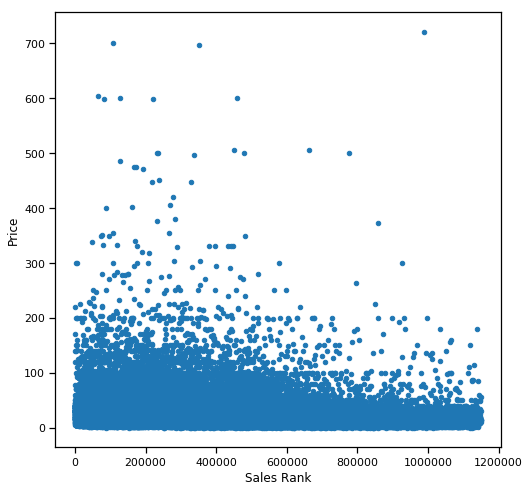

In [162]:
# the scatter plot of price and sales rank
ax = price_sale.plot.scatter(x='salesRank', y='price', figsize=(8, 8))
ax.set_xlabel('Sales Rank')
ax.set_ylabel('Price')
plt.savefig('rank-price.png')

In [89]:
# Pearson coefficient
r, p = sp.stats.pearsonr(price_sale['price'], price_sale['salesRank'])
print("Pearson's correlation coefficient: " + str(r) + "\n2-tailed p-value: " + str(p))

Pearson's correlation coefficient: -0.10131897529225159
2-tailed p-value: 1.6617704686971954e-219


There are too many points in the plot but there seems to be a negative relation between price and sales rank. From the Pearson correlation coefficient we notice a very weak negative correlation between the two factors. Now we'd like to divide the sales rank into intervals of length 100000 and see how the average price and median price change over rank intervals.

In [164]:
# divide rank intervals as [0,100000), [100000, 200000), ...
price_sale['rankInterval'] = price_sale['salesRank'].apply(lambda rank: int(rank)//100000*100000)
price_sale.head()

,price,salesRank,rankInterval
asin,,,
0000143561,12.99,376041,300000
0000589012,15.95,1084845,1000000
0000143529,19.99,463562,400000
0000143502,62.51,467172,400000
0000143588,9.15,309405,300000


In [173]:
# group by rank interval
price_rankinterval = price_sale[['price', 'rankInterval']].groupby(['rankInterval'])
interval_average_price = price_rankinterval.mean()
interval_median_price = price_rankinterval.median()

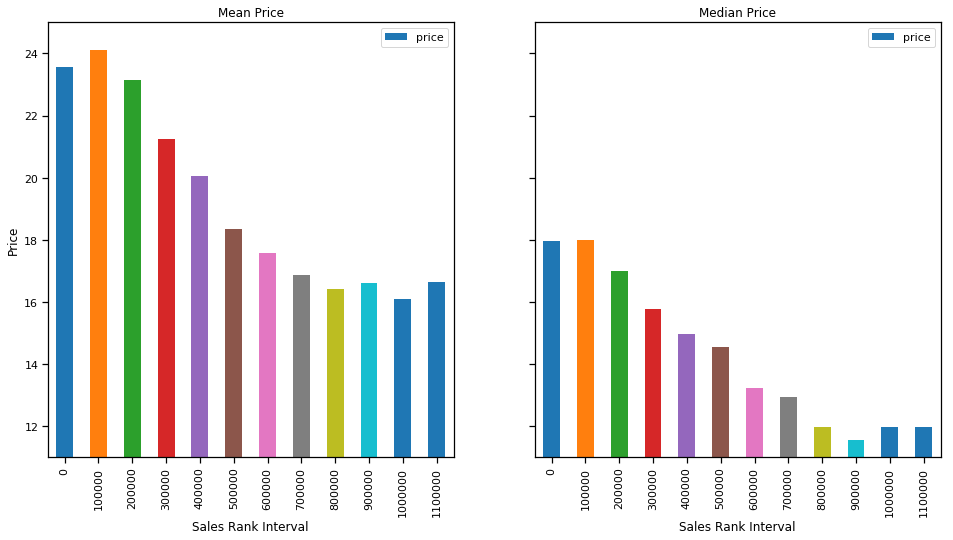

In [181]:
# plot mean price and median price of each rank interval
fig, axs = plt.subplots(1, 2, sharey=True)
interval_average_price.plot(y='price', kind='bar', title='Mean Price', ax=axs[0], ylim=[11, 25], figsize=(16, 8))
interval_median_price.plot(y='price', kind='bar', title='Median Price', ax=axs[1])
axs[0].set_xlabel('Sales Rank Interval')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('Sales Rank Interval')
plt.savefig('rankinterval-price.png')

So we can observe the prices for higher-ranked movies are higher in general. This partly proves that pricey products are likely to be valuable and cheap products may not be of good quality.

### Analyze the distribution of prices

Now we are curious about the distribution of prices, so we do some simple analysis on prices.

In [51]:
# statistical description of price
price_sale['price'].describe()

count    96930.000000
mean        21.498796
std         22.979707
min          0.010000
25%          9.660000
50%         15.280000
75%         24.990000
max        719.960000
Name: price, dtype: float64

The mean is about 21.5 dollars and the median is about 15.3 dollars. The max amount 720 dollars is definitely an outlier, and those outliers with high prices lift up the mean.

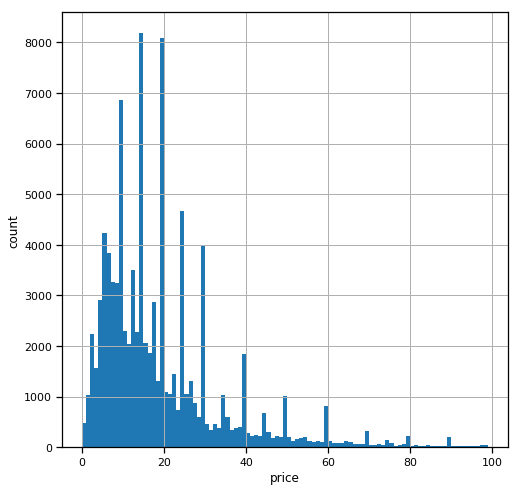

In [53]:
# plot the histogram of price distribution in intervals of length 1
plt.xlabel('price')
plt.ylabel('count')
ax = price_sale['price'].hist(bins=range(0,100), figsize=(8, 8))

We get some interesting results. When we divide the price axis to intervals of length 1, we find that the price count is not smoothly changing with growing price.

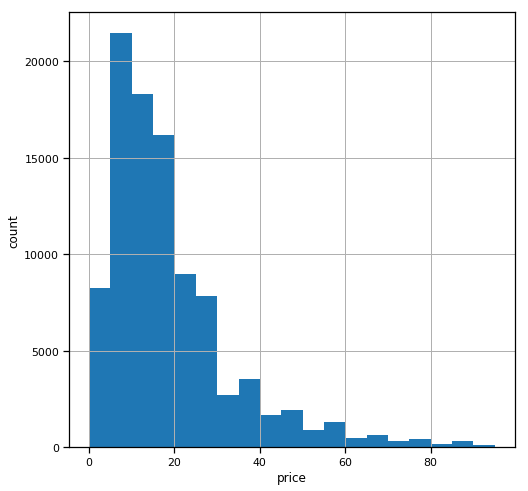

In [55]:
# plot the histogram of price distribution in intervals of length 5
plt.xlabel('price')
plt.ylabel('count')
ax = price_sale['price'].hist(bins=range(0,100,5),figsize=(8, 8))

If we divide the price axis to intervals of length 5, the histogram seems to be more smooth. We could find that Amazon have special preference on some specific price numbers:

In [35]:
# count most frequent prices
price_count = price_sale['price'].value_counts()
price_count.head(20)

14.98    2671
19.99    2326
19.98    2075
19.95    2068
14.99    1834
9.99     1767
24.95    1705
14.95    1498
2.99     1494
29.95    1434
9.98     1433
24.98    1149
29.99    1010
24.99     929
9.95      846
29.98     733
5.98      716
17.99     708
6.99      691
5.00      687
Name: price, dtype: int64

As we can see, Amazon doesn't like integers - they sell at 14.98 rather than 15, and sell at 19.99 rather than 20. This is a common known selling trick. Besides, the price numbers are likely to be close to a multiple of 5.

# 2.2) Analysis on Ratings

### Group ratings by movies

We group the ratings by the same movie(same `asin`) so we can analyse ratings for a specific movie.

In [68]:
# groupby movie
movie_ratings = ratings.groupby(['asin'])

In [69]:
# get average rating on each movie
movie_mean_ratings = movie_ratings.mean()
movie_mean_ratings.head()

,overall
asin,
0000143502,5.000000
0000143529,5.000000
0000143561,2.000000
0000143588,5.000000
0000589012,4.103448


In [70]:
movie_mean_ratings.shape

(131860, 1)

We get the mean ratings for 131860 movies, less than 136999 movies in total. So there may be some movies with too few ratings so they are not in the 5-core dataset. Now we merge the movie average ratings with metadata.

In [126]:
# merge ratings with ranks for further analysis
rating_rank_merge = pd.merge(movie_mean_ratings, metadata, on='asin')[['overall', 'salesRank']]
rating_rank_merge.head()

,overall,salesRank
asin,,
0000143502,5.000000,467172
0000143529,5.000000,463562
0000143561,2.000000,376041
0000143588,5.000000,309405
0000589012,4.103448,1084845


We would like to analyze the correlation between overall average ratings and sales rank.

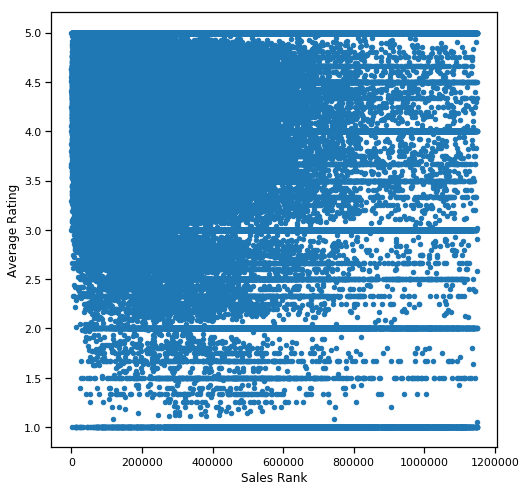

In [170]:
# plot scatter of sales rank and mean rating
ax = rating_rank_merge.plot.scatter(x='salesRank', y='overall',figsize=(8, 8))
ax.set_xlabel('Sales Rank')
ax.set_ylabel('Average Rating')
plt.savefig('rank-rating.png')

In [128]:
# Pearson Coefficient
r, p = sp.stats.pearsonr(rating_rank_merge['salesRank'], rating_rank_merge['overall'])
print("Pearson's correlation coefficient: " + str(r) + "\n2-tailed p-value: " + str(p))

Pearson's correlation coefficient: -0.07527765387414483
2-tailed p-value: 5.624678085001144e-165


Since the amount of data is huge, it is hard for us to find a pattern from the scatter plot. Besides, the correlation coefficient shows a very weak negative correlation.

Same as before, now we consider dividing salesRank to several intervals and see if the plot will be easy to read. We divide the salesRank to intervals of length 100000, 12 intervals in total.

In [130]:
# divide rank intervals as [0,100000), [100000, 200000), ...
rating_rank_merge['rankInterval'] = rating_rank_merge['salesRank'].apply(lambda rank: int(rank)//100000*100000)
rating_rank_merge.head()

,overall,salesRank,rankInterval
asin,,,
0000143502,5.000000,467172,400000
0000143529,5.000000,463562,400000
0000143561,2.000000,376041,300000
0000143588,5.000000,309405,300000
0000589012,4.103448,1084845,1000000


We use the mean of each movie's average ratings as the average rating for the rank interval.

In [176]:
# group by rank interval
rating_rankinterval_merge = rating_rank_merge[['overall', 'rankInterval']].groupby(['rankInterval'])
interval_average_rating = rating_rankinterval_merge.mean()
interval_median_rating = rating_rankinterval_merge.median()

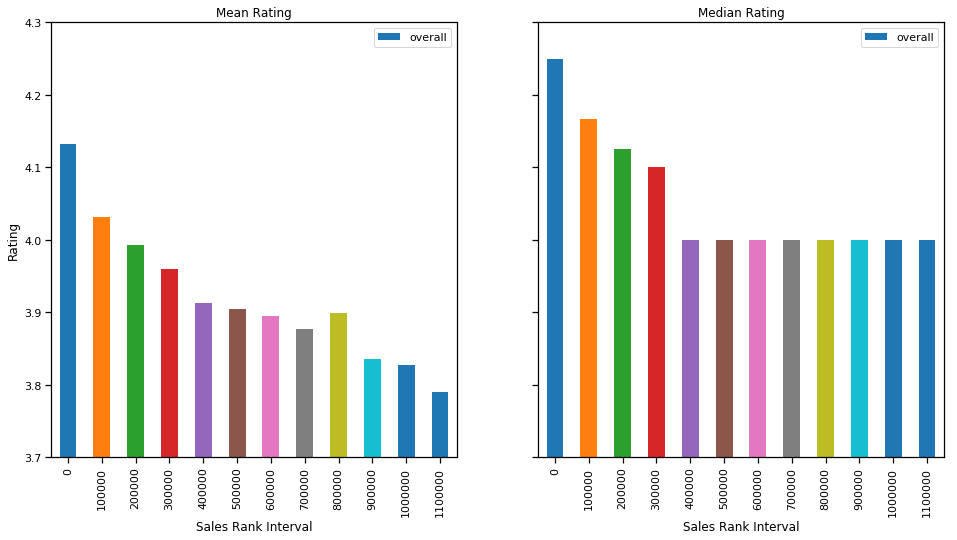

In [180]:
# plot mean price and median rating of each rank interval
fig, axs = plt.subplots(1, 2, sharey=True)
interval_average_rating.plot(y='overall', kind='bar', title='Mean Rating', ax=axs[0], ylim=[3.7, 4.3], figsize=(16, 8))
interval_median_rating.plot(y='overall', kind='bar', title='Median Rating', ax=axs[1])
axs[0].set_xlabel('Sales Rank Interval')
axs[0].set_ylabel('Rating')
axs[1].set_xlabel('Sales Rank Interval')
plt.savefig('rankinterval-rating.png')

As we can see, there is a decrese in the average and median rating as sales rank interval grows. This matches our instinct that best sellers will receive higher ratings, and that movies with a high reputation tend to sell better.

### Group ratings by time

Now we consider group ratings by time so we can analyze the trend of ratings over time.

In [79]:
# group ratings by time
time_ratings = ratings.groupby(['time'])

In [80]:
# average rating on each day
time_mean_ratings = time_ratings.mean()
time_mean_ratings.head()

,overall
time,
1997-08-09,4.0
1997-08-19,1.0
1997-08-23,5.0
1997-09-14,5.0
1997-09-20,5.0


In [78]:
# statistical description on rating time
ratings['time'].describe()

count                 3061065
unique                   5981
top       2014-03-25 00:00:00
freq                     5834
first     1997-08-09 00:00:00
last      2014-07-23 00:00:00
Name: time, dtype: object

In [81]:
time_mean_ratings.shape

(5981, 1)

Now we would like to pick a certain movie and see how its ratings change over time. Is there any trend for a hit movie? First we extract movies which rank top 100 in 'Moives and TV' in our dataset.

In [184]:
# extract top 100 in rank
top100_movies = price_sale[price_sale['salesRank']<=100]
top100_movies

,price,salesRank,rankInterval
asin,,,
B0083SBMGW,219.00,12,0
B00G5G7EXY,29.99,51,0
B00GQQ77IU,39.99,38,0
B00GQQ75QO,29.95,83,0
B00K2CHVSK,44.95,84,0
B00L4K3MLE,39.99,71,0


So we would like choose the first one - B0083SBMGW which ranks 12th in 'Movies & TV'.

In [203]:
# select ratings on B0083SBMGW and sort by time
bestseller_ratings = ratings[ratings['asin']=='B0083SBMGW'].sort_values('time')
bestseller_ratings.head()

,reviewerID,asin,overall,time
4095110,ALLVXWH9HCW2X,B0083SBMGW,5.0,2012-05-18
4095488,A1V6Q88B7KNSSU,B0083SBMGW,2.0,2012-06-01
4095554,A1TUOBR9DYKZJA,B0083SBMGW,3.0,2012-06-01
4095192,A3VSJG6D62P1HU,B0083SBMGW,5.0,2012-06-01
4095060,A2CKFK43Z4CTPF,B0083SBMGW,5.0,2012-06-05


We'd like to group monthly ratings to see a clear trend.

In [214]:
# get month from given date
bestseller_ratings['month'] = bestseller_ratings['time'].dt.to_period('M')
bestseller_ratings.head()

,reviewerID,asin,overall,time,month
4095110,ALLVXWH9HCW2X,B0083SBMGW,5.0,2012-05-18,2012-05
4095488,A1V6Q88B7KNSSU,B0083SBMGW,2.0,2012-06-01,2012-06
4095554,A1TUOBR9DYKZJA,B0083SBMGW,3.0,2012-06-01,2012-06
4095192,A3VSJG6D62P1HU,B0083SBMGW,5.0,2012-06-01,2012-06
4095060,A2CKFK43Z4CTPF,B0083SBMGW,5.0,2012-06-05,2012-06


In [217]:
# group monthly ratings
bestseller_monthly_rating = bestseller_ratings[['overall', 'month']].groupby(['month'])
bestseller_monthly_average_rating = bestseller_monthly_rating.mean()

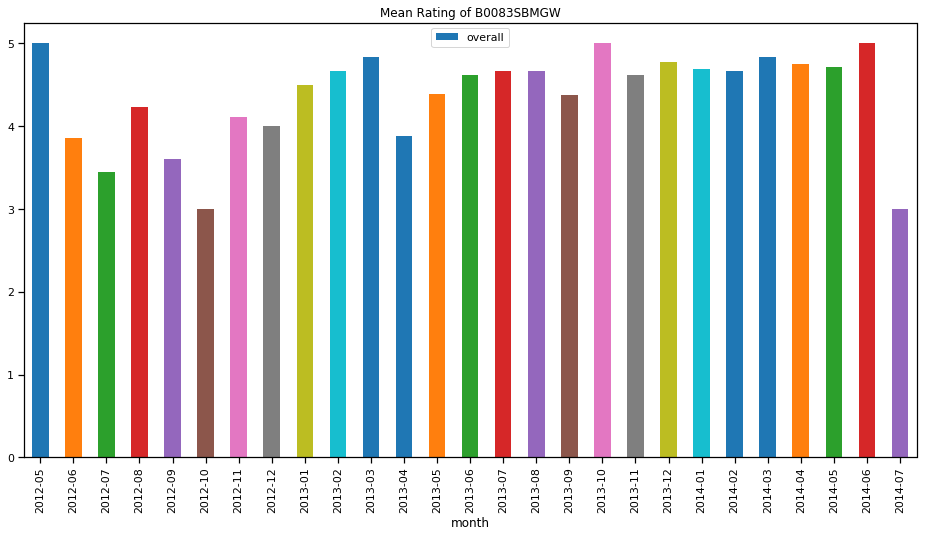

In [225]:
# plot monthly ratings trend
bestseller_monthly_average_rating.plot(y='overall', kind='bar', title='Mean Rating of B0083SBMGW', figsize=(16, 8))
plt.savefig('monthly-rating.png')

There is not an increasing or decreasing trend in the monthly rating. However, we can observe that the average rating has unstable rise and fall in the first few months, and turns out to be stable gradually.

### Group ratings by reviewers

After grouping the ratings by movies, we can think about grouping ratings by reviewers. Different reviewer has a different average rating, so it is meaningful for us to do a normalization to assign different weights on different reviewers' ratings in our later work, which will lead to a more reasonable weighted average rating.

In [75]:
# groupby reviewers
reviewer_ratings = ratings.groupby(['reviewerID'])

In [76]:
# get each reviewer's mean rating
reviewer_mean_ratings = reviewer_ratings.mean()
reviewer_mean_ratings.head()

,overall
reviewerID,
A00005181SC9PSCD58LCG,4.5
A0001392IVCRENBEIEYS,1.0
A0002090WKEMAO8KOWKM,5.0
A000222418JVUV9W33GLH,4.5
A00025603PJ3GM9KBM8TU,1.0


In [77]:
reviewer_mean_ratings.shape

(1415339, 1)

So there are 1415339 reviewers in total.

# 3. TMDB Descriptive Statistical Analysis

# 3.1) TMDB Movie Genre Evoluation 

To make a hit movie, in addtion to simple numbers like budget and popularity, other text information is also informative. For example, the genres have a huge influence of movie reviews. In typical years , specific genres of movie tend to lead a fashion.

We get the evoluation plot of all types of movie with time above.

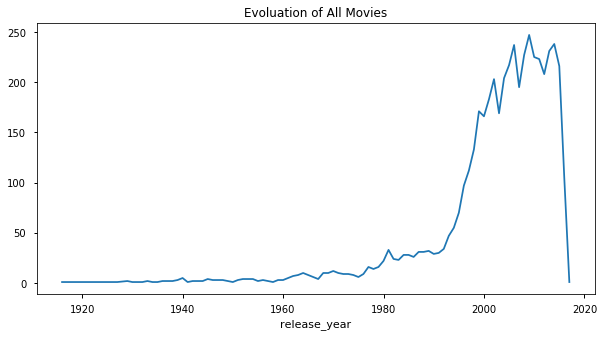

In [26]:
tmdb=tmdb_data.copy()
tmdb_by_year = tmdb.groupby('release_year').size().plot(figsize=(10,5),title='Evoluation of All Movies')

We can see that agter 2000, the number of movies has a explosive increase.

We define a get_count function to get the count of each element in a list feature. The function can be used later not limitted to genres information, but also other preprocessed columns like spoken_launguages and procution_countries.

In [27]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count
genres_count = pd.Series(get_count(tmdb['genres'])).sort_values(ascending=False)
genres_count

Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
dtype: int64

Now we c get the number of each genre of movies with their count number in a descending order.

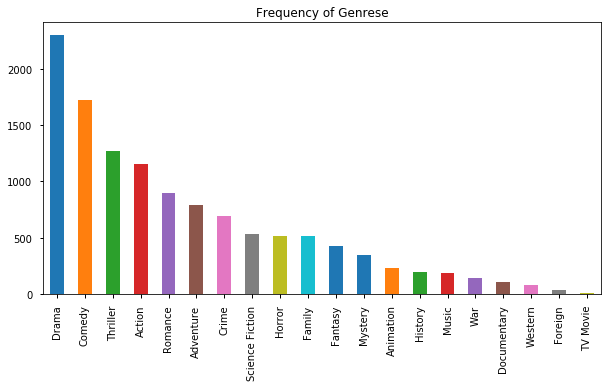

In [28]:
genres_count.plot(kind = 'bar', title = 'Frequency of Genrese',figsize=(10,5))

We get the bar chart of 20 genres of movies with their count number. We can see the Drama account for most.

Then we wish to observe the evoluation of each genre with time. We creae a new dataset with genres as its columns and releasr_year as its index, We can easily get the acount in the genre and get the resulted dataframe.

In [29]:
genres_by_year = tmdb.groupby('release_year').genres.sum()
genres_stat = pd.DataFrame([], index = genres_by_year.index, columns = genres_count.index[0:20])
for temp_year in genres_stat.index:
    for temp_genre in genres_stat.columns:
        genres_stat.loc[temp_year,temp_genre] = genres_by_year[temp_year].count(temp_genre) 
genres_stat.head()

,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie
release_year,,,,,,,,,,,,,,,,,,,,
1916.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1925.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1927.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1929.0,2,0,1,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1930.0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


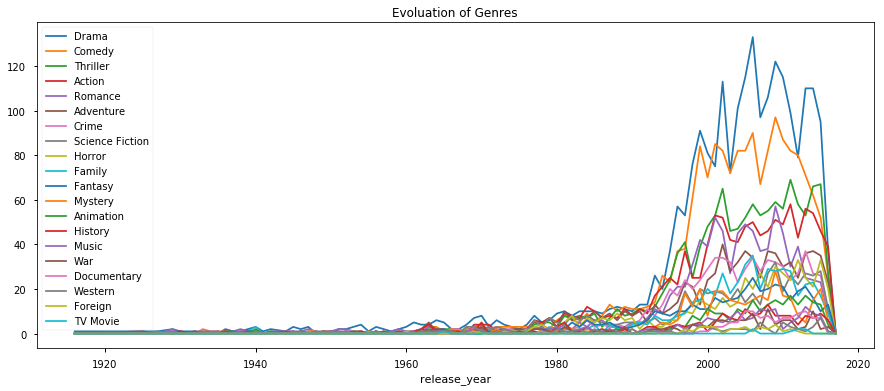

In [30]:
genres_stat.plot(figsize=(15,6),title='Evoluation of Genres')

We plot the evoluation of genres of movies with time. We can see that drama has always been a leading trend in history, followed by comedy. The trend of other genres have been fluctuating through time and market of movies for that are usually changing.

# 3.2) Geographic Distribution

Then we focus on the production countries of movies. Since different countries lead to different cultures and different strengths of countries can lead to different tastes of movies. For example, America is famous for its technology and thus Ameican science fiction movies often take more budget, but they may lead to higher ratings in the other hand. Japan is famous for its worldwide animations and Japanese anaimations often take a large percentage in the market.

In [31]:
country_count = pd.Series(get_count(tmdb['production_countries'])).sort_values(ascending=False)
country_count_df=pd.DataFrame(country_count)
country_count_df['country']=country_count_df.index
country_count_df['count']=country_count_df[0]
country_count_df.reset_index(inplace=True)
country_count_df=country_count_df[['country','count']]
country_count_df.head(10)

,country,count
0,United States of America,3956
1,United Kingdom,636
2,Germany,324
3,France,306
4,Canada,261
5,Australia,110
6,Italy,72
7,Spain,71
8,China,59
9,Japan,58


We use the get_count function again to get the count of each potential countries and get the couts in a descending order.

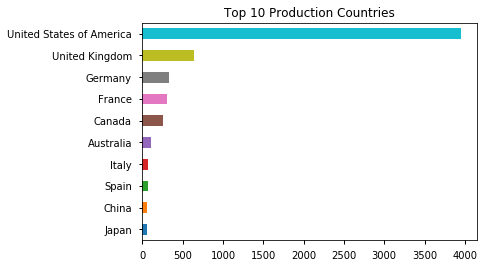

In [63]:
country_count_show=country_count[:10]
country_count_show=country_count_show[::-1]
country_count_show.plot(kind='barh',title='Top 10 Production Countries')

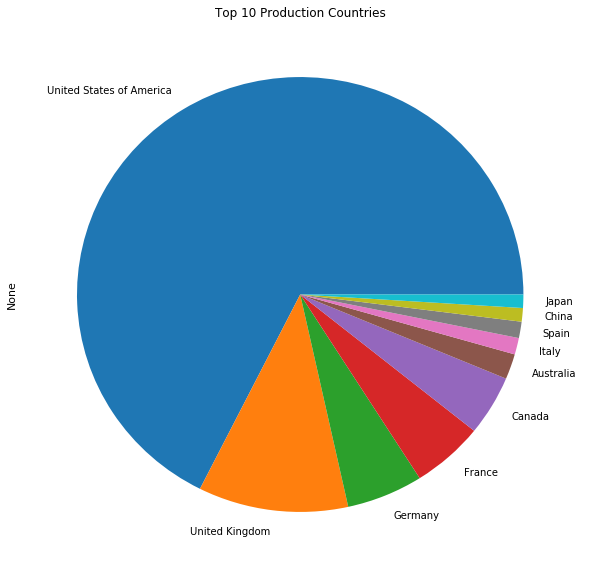

In [64]:
country_count_show_2=country_count[:10]
country_count_show_2.plot(kind='pie',figsize=(10,10),title='Top 10 Production Countries')

Also, we get a horizental bar chart and a pie chart to observe the geographic distribution of movies. We can see in tmdb datasets, there are many more American movies than other countries, followed by United Kindoms and Germany.

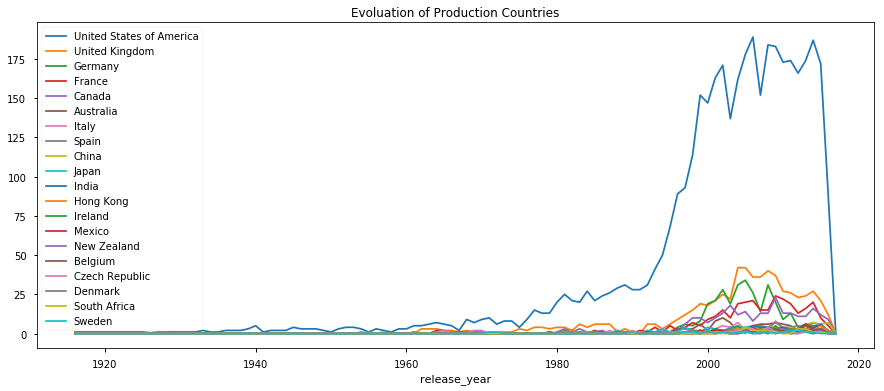

In [34]:
country_by_year = tmdb.groupby('release_year').production_countries.sum()
country_stat = pd.DataFrame([], index = country_by_year.index, columns = country_count.index[0:20])
for temp_year in country_stat.index:
    for temp_country in country_stat.columns:
        country_stat.loc[temp_year,temp_country] = country_by_year[temp_year].count(temp_country) 
country_stat.plot(figsize=(15,6),title='Evoluation of Production Countries')

We plot the evoluation of production countries of movies with time. We can see that America has always been the leading country in movie industry, followed by United Kindom. The trend of other countries have been flucuating through time and market of movies for that are usually changing.But we can observe that the overall trend is that the numbers of all movies a country makes has been in an increase trend in history despite the overall decrease trend in recent years.

Later, we plan to correlate the geographic information with other features in hit movie analysis in section 4 and we plan to utilize folium to show the correlation with other features in the world map, which is more visually readable.

# 3.3) Language and Company Distribution

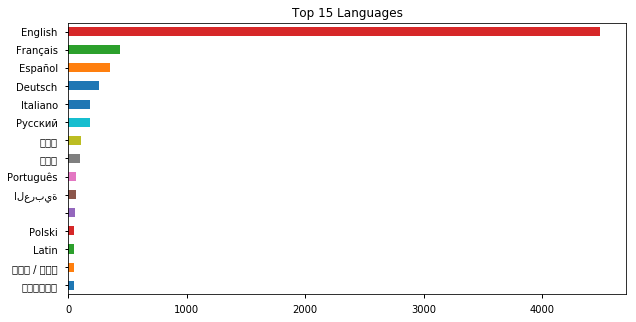

In [35]:
language_count = pd.Series(get_count(tmdb['spoken_languages'])).sort_values(ascending=False)
language_count_show=language_count[:15]
language_count_show=language_count_show[::-1]
language_count_show.plot(kind='barh',figsize=(10,5),title='Top 15 Languages')

We observe English is the dominant Language in tmdb movies.

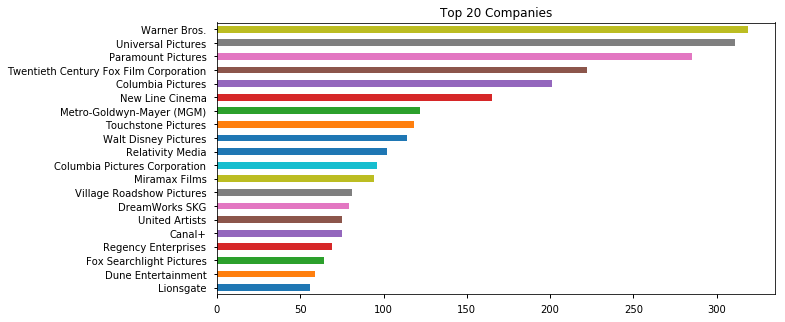

In [36]:
company_count = pd.Series(get_count(tmdb['production_companies'])).sort_values(ascending=False)
company_count_show=company_count[:20]
company_count_show=company_count_show[::-1]
company_count_show.plot(kind='barh',figsize=(10,5),title='Top 20 Companies')

We can get the top popular spoken launguages and production companies as above. In case of contingency, the top mamebers will be utilized in future detailed analysis.

# 3.4) Influence of Celebrity

Besides genres and production countries, there are some other features that also bring a huge difference to a movie rating, like spoken launguages. In this section,we focus on the influence of celebrity. We wish to oberve whether a famous person who participate in the movie will have an influence on the movie.

Usually there are lots of jobs involved in movie productions, like casts, directors, producer, 3D direrecot and so on. However, the way of getting a cast influence is the same as genres and production countires as above due to the same data strcture of list in dataframe features. So we put our focus on famous people in crew. Since there are too many jobs in crew, we choose directors for analysis since a director can influence the story line and overall prensentation of a movie.

In [37]:
def get_direcotr_count(col):
    temp_count = dict()
    for temp_director in col:
            if temp_director in temp_count:
                temp_count[temp_director] += 1
            else:
                temp_count[temp_director] = 1
    return temp_count

First, we define a function get_director_count to get the dictionary of each director in the dataset and their corresponding count.

In [117]:
director_count = pd.Series(get_direcotr_count(tmdb['director'])).sort_values(ascending=False)
director_count=director_count[1:]
director_count_df=pd.DataFrame(director_count)
director_count_df['director']=director_count_df.index
director_count_df['count']=director_count_df[0]
director_count_df.reset_index(inplace=True)
director_count_df=director_count_df[['director','count']]
director_count_df.head(10)

,director,count
0,Steven Spielberg,27
1,Woody Allen,21
2,Clint Eastwood,20
3,Martin Scorsese,20
4,Robert Rodriguez,16
5,Spike Lee,16
6,Ridley Scott,16
7,Renny Harlin,15
8,Steven Soderbergh,15
9,Oliver Stone,14


We then turn the count into a dataframe in a descending order and show the distribution in a horizontal bar chart.

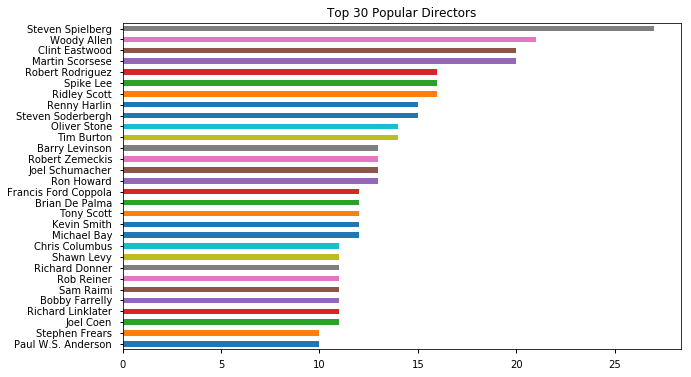

In [118]:
director_count_show=director_count.head(30)
director_count_show=director_count_show[::-1]
director_count_show.plot(figsize=(10,6),kind='barh',title='Top 30 Popular Directors')

The number of movies each director directs is shown above. It shows the popularity of top 30 popular directors.

However, the influence of a director is not only shown by how many movies he/she directs, it's also shown by how many revenue he can bring to a movie, and that's considered as a key part of a hit movie.

We then sum the total revenue of all movies a director directs and show the total_revenue in following dataframe.

In [119]:
director_count_df['total_revenue']=0
for temp_director in director_count_df.director:
    total_tmdb_temp_director=tmdb[tmdb['director']==temp_director]
    temp_total_revenue=total_tmdb_temp_director.revenue.sum()
    temp_index=director_count_df[director_count_df['director']==temp_director].index
    director_count_df.total_revenue[temp_index]=total_tmdb_temp_director.revenue.sum()
director_count_df.head()

,director,count,total_revenue
0,Steven Spielberg,27,9147393164
1,Woody Allen,21,669101038
2,Clint Eastwood,20,2512058888
3,Martin Scorsese,20,1956635998
4,Robert Rodriguez,16,1109899581


We use total_revenue/count to calculate the average revenue a director bring to a movie. Since a director who participates in only  a few movies do not contain much information, we choose the top 20 directors with their average revenue and show the result below with a dataframe and a horizontal chart.

<BarContainer object of 20 artists>

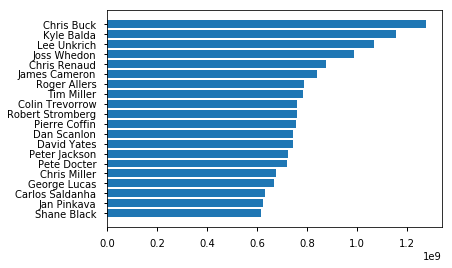

In [121]:
director_df=director_count_df.copy()
director_df['avg_revenue']=director_df['total_revenue']/director_df['count']
director_df=director_df.sort_values(by='avg_revenue',ascending=False)

director_df=director_df.reset_index()
director_df=director_df[['director','avg_revenue']]
director_df=director_df.head(20)
temp_x=director_df['avg_revenue']
temp_x=temp_x[::-1]
temp_y=director_df['director']
temp_y=temp_y[::-1]
plt.barh(temp_y,temp_x)

In this section, we get the number of movies and average revenue of each director and show the result by plots. We will further correlate the information with other feature in machine learning and other approaches in later section in 4. 

# 3.5) Simple Keywords Analysis

Keyword is also an important element that representsn for the theme of a movie and it's worth analyzing in deep text processing domain like natural language preocessing. In the task of descriptive statiscs, we use wordcloud library to show the frequencey of each potential keyword and plot it above.

Here we show the total keywords among all movies in datasets. The keywords plot can be different if we divide movies by genres, countries and directors, but the approach is all the same, we will further correlate the features in merged data in section 4 until milestone 3.

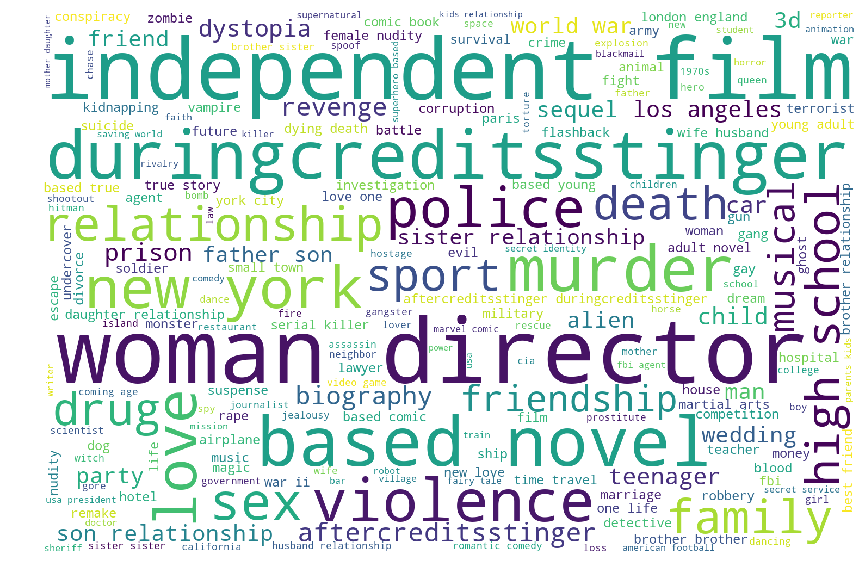

In [40]:
keywords_all= ''
for temp_keywords in tmdb['keywords']:
    for temp_keyword in temp_keywords:
        keywords_all=keywords_all+temp_keyword+' '
    
wc = WordCloud(background_color="white",width=1500, height=1000, margin=2).generate(keywords_all)
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

We can also get the top 10 frequent keywords among the movies by a bar chart.

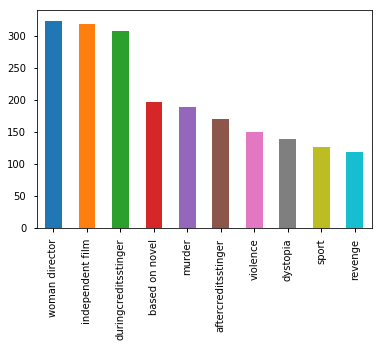

In [41]:
country_count = pd.Series(get_count(tmdb['keywords'])).sort_values(ascending=False)
country_count_show= country_count.head(10)
country_count_show.plot(kind='bar')

# Milestone 2 Conclusion

1) Finish data loading from TMDB Datasets and Amazon Datasets, and implement data wrangling and cleaning according to the characteristics of each dataset(including enrich, filter, transform). Thus we are more aware of the datasets and future implementations in the project

2) Do data preprocessing and merge for each dataset for future potential analysis approaches and save the preprocessed dataframes into a pickle file for futher efficient use

3) Implement necessary descriptive statistics tasks in seperate dataframes and corresponding visualization for potentially informative features for further analysis.

4) Design the machine learning appraoch inside TMDB dataset and merged dataset to implement regression of movie profit and Amazon rating classification, as well as the approaches of hyperparameter tuning and greedy selection for most informative features that affect the movies

5) More aware of the datasets and future implementations in the project and made future plans in the project until milestone 3

<h1><i><font color=blue>Milestone 3</font></i></h1>

# 3. TMDB Descriptive Statistical Analysis(Cont.)

# 3.6) Profit Regression Analysis by Machine Learning

We plan to implement a machine learning analysis inside TMDB data. We wish to analyze the profit as the output for regression. Firstly, we choose the best hyperparameters for the whole training sets by cross validation. Then we plan to use greedy backward selection to choose the top features that affect the profit the movie by corss vailadation.By machine learning, we can get the top features that affect the movie profit.

Here is a machine learning regression algorithm for profit. We wish to explore the features of a movie instead of just money number like budget and revenue.

We choose the following features as the digit features. We choose the profit we get in the preprocessing section as the labels for later regression.

In [4]:
tmdb_data=pd.read_pickle('tmdb_data.pkl')
tmdb_ml=tmdb_data.copy()
tmdb_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count,director,release_year,profit,title_change
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2787965087,162.0,"[English, Español]",7.2,11800,James Cameron,2009.0,10.763566,1


We take a glance at the correlation among value features for profit.

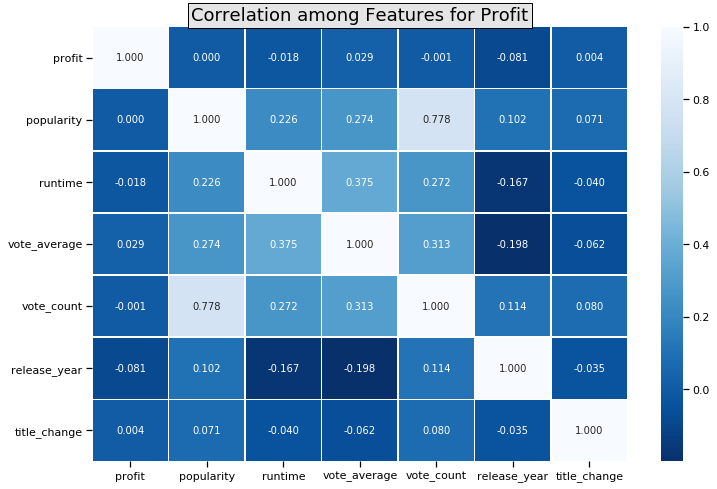

In [10]:
tmdb_cor=tmdb_ml[['profit','popularity','runtime','vote_average','vote_count','release_year','title_change']]
potential_type = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
tmdb_cor = tmdb_cor.select_dtypes(include=potential_type)
plt.figure(figsize=(12, 8))
sns.heatmap(tmdb_cor.corr(), annot = True, fmt = ".3f", linewidths = .5, cmap = 'Blues_r');
plt.title('Correlation among Features for Profit', fontsize=18, bbox={'facecolor':'1.9', 'pad':3})
plt.show()

In [16]:
tmdb_ml = tmdb_data.copy()
features=['popularity','runtime','vote_average','vote_count','release_year','title_change']
labels=['profit']
tmdb_features = tmdb_ml[features]
tmdb_labels=tmdb_ml[labels]

We choose genres, countries, directors and spoken language as factors that may affect the profits. Since the text data are stored in list data structure, we can not use simple `get_dummy`. Thus we use the same approaches in previous sections. 
Also, because features in low-frequency have much contingency, we only choose the top 10 or 20 in these features. For example, a famous director may influence a movie to a large degree, however, the information of those who direct 1 or 2 movies is not informative and can often lead to outliers or noise in machine learning analysis.

In [19]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count

In [20]:
def extract(genres,tmdb_features,number):
    genres_count = pd.Series(get_count(tmdb_data[genres])).sort_values(ascending=False)
    genres_count=genres_count[:number]
    for temp_genre in genres_count.index[:10]:
            tmdb_features[temp_genre]=0
    for temp_genre in genres_count.index:
        for i in range(len(tmdb_features)):
            if temp_genre in tmdb_data['genres'].values[i]:
                tmdb_features[temp_genre].values[i]=1

In [21]:
extract('genres',tmdb_features,20)
extract('production_countries',tmdb_features,10)
extract('spoken_languages',tmdb_features,10)
extract('production_companies',tmdb_features,10)

In [26]:
def get_direcotr_count(col):
    temp_count = dict()
    for temp_director in col:
            if temp_director in temp_count:
                temp_count[temp_director] += 1
            else:
                temp_count[temp_director] = 1
    return temp_count

In [35]:
director_count = pd.Series(get_direcotr_count(tmdb_data['director'])).sort_values(ascending=False)
director_count=director_count[:10]
for temp_director in director_count.index:
    tmdb_features[temp_director]=0
for temp_director in director_count.index:
    for i in range(len(tmdb_features)):
        if temp_director in tmdb_data['director'].values[i]:
            tmdb_features[temp_director].values[i]=1

We get the columns for training features.

In [42]:
tmdb_features.columns

Index(['popularity', 'runtime', 'vote_average', 'vote_count', 'release_year',
       'title_change', 'Drama', 'Comedy', 'Thriller', 'Action', 'Romance',
       'Adventure', 'Crime', 'Science Fiction', 'Horror', 'Family', 'Fantasy',
       'Mystery', 'Animation', 'History', 'Music', 'War', 'Documentary',
       'Western', 'Foreign', 'TV Movie', 'United States of America',
       'United Kingdom', 'Germany', 'France', 'Canada', 'Australia', 'Italy',
       'Spain', 'China', 'Japan', 'English', 'Français', 'Español', 'Deutsch',
       'Italiano', 'Pусский', '普通话', '日本語', 'Português', 'العربية',
       'Warner Bros.', 'Universal Pictures', 'Paramount Pictures',
       'Twentieth Century Fox Film Corporation', 'Columbia Pictures',
       'New Line Cinema', 'Metro-Goldwyn-Mayer (MGM)', 'Touchstone Pictures',
       'Walt Disney Pictures', 'Relativity Media', '', 'Steven Spielberg',
       'Woody Allen', 'Martin Scorsese', 'Clint Eastwood', 'Robert Rodriguez',
       'Ridley Scott', 'Spike Le

In case of extraordinary features, we again use dropna.

In [43]:
tmdb_features=tmdb_features.dropna(how='all')
tmdb_features=tmdb_features.drop('',axis=1)
tmdb_features=tmdb_features.fillna(0)
tmdb_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Martin Scorsese,Clint Eastwood,Robert Rodriguez,Ridley Scott,Spike Lee,Renny Harlin,Steven Soderbergh
0,150.437577,162.0,7.2,11800,2009.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,139.082615,169.0,6.9,4500,2007.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,107.376788,148.0,6.3,4466,2015.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,112.312950,165.0,7.6,9106,2012.0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,43.926995,132.0,6.1,2124,2012.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


We split the data into training set and testing set with a ratio of 80% and 20%. Since we will do randomization in later cross validation process. Here we just take the first 80% of raw dataset to training set.

In [44]:
inf_index=tmdb_labels[tmdb_labels['profit']>10].index
tmdb_features=tmdb_features.drop(inf_index,axis=0)
tmdb_labels=tmdb_labels.drop(inf_index,axis=0)
tmdb_labels=tmdb_labels.fillna(0)

In [45]:
max_index=tmdb_labels[tmdb_labels['profit']==max(tmdb_labels['profit'])].index
tmdb_labels=tmdb_labels.drop(max_index)
tmdb_features=tmdb_features.drop(max_index)

In [46]:
tmdb_len=len(tmdb_features)
train_features= tmdb_features[:round( 0.9 * tmdb_len )]
test_features = tmdb_features[round( 0.9 * tmdb_len ):]
train_labels= tmdb_labels[:round( 0.9 * tmdb_len )]
test_labels= tmdb_labels[round( 0.9 * tmdb_len ):]

Then we do the normalization. We calculate the mean and std of each column of feature in training set and use the calculated result to realize the normalization in both training and testing datasets.

In [47]:
for temp_col in tmdb_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std
train_features=train_features.dropna(how='any')
train_features.head()

,popularity,runtime,vote_average,vote_count,release_year,title_change,Drama,Comedy,Thriller,Action,...,Relativity Media,Steven Spielberg,Woody Allen,Martin Scorsese,Clint Eastwood,Robert Rodriguez,Ridley Scott,Spike Lee,Renny Harlin,Steven Soderbergh
1,3.985178,2.843772,0.769181,3.046598,0.35970,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
2,2.901219,1.852660,0.171765,3.019144,1.08306,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
3,3.069977,2.654989,1.466167,6.765737,0.81180,0.229022,1.047317,-0.76145,1.606535,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
4,0.731998,1.097528,-0.027374,1.128084,0.81180,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296
5,3.185767,1.427898,-0.226513,2.300509,0.35970,0.229022,-0.954580,-0.76145,-0.622301,1.659385,...,-0.161508,-0.07113,-0.072896,-0.065554,-0.067463,-0.061561,-0.063588,-0.059466,-0.061561,-0.057296


So far we standardize the values of each feature in the data to have mean 0 and variance 1.

We use random forest regressor to deal with the regression. Firstly, we import the library.

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
tmdb_model =  RandomForestRegressor(n_estimators = 20, max_depth=5, oob_score = True)
tmdb_model.fit(train_features,train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

We take a glance at the result of the random forest algorithm, and the main metric of a regression is set as mean squard error (mse). The hyperparameters are chosen randomly.

In [53]:
test_predict_array=tmdb_model.predict(test_features)
test_labels_array=np.array(test_labels['profit'])
temp_mse=mean_squared_error(test_predict_array, test_labels_array) 
print('mean square error is '+str(temp_mse))

mean square error is 1.430923044595997


Plot the test result upon running the trained random forest model in testing set.

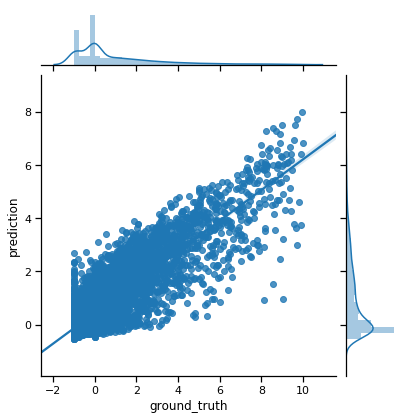

In [62]:
tmdb_pred_label=pd.DataFrame({'ground_truth':test_labels_array,'prediction':test_predict_array})
sns.jointplot(x='ground_truth',y='prediction',data=tmdb_pred_label,kind='reg')

We can see that most prediction and labels have a linear relationship. However, there are too many outliers, and the ranges are not wide enough, which is to say, a simple random forest model with randomly chosen hyperparameters may not be enough to train a regresor, so later we will use grid search, cross validation and greedy backward selection to improve the model and find the top related features.

For later manually created cross validation, we prepare for it with a function of data split index, `build_k_indices`. Among the inputs, `y` is the data we will split in later cross validation, the `k_folder` is the number we want to divide our dataset with (in the task `k_folder` is just 5) and seed is random number. We use `np.random.seed` to randomize the index in input dataset and use `k_indices` to split the randomized data into `k_folder` divisions.

In [54]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [31]:
n_estimators_range=range(10,110,10)
max_depth_range= range(1,21)
ne_score=pd.DataFrame({'n_estimators':np.array(n_estimators_range),'mse':0.0})
mp_score=pd.DataFrame({'max_depth':np.array(max_depth_range),'mse':0.0})
rfc_score= pd.merge(ne_score, mp_score)
rfc_score= rfc_score[['n_estimators','max_depth','mse']]

Also for each potential combination of 2 parameters, we use random forest regressor with cross validation to get the mean square error of the chosen combination, and fill in the accuracy of the dataframe `rfc_score` in corresponding row. The approach complies to the grid search. And after running all combinations, the output of `rfc_score` is as follows.

In [32]:
k_indices=build_k_indices(train_labels,5,10)
for i in range(len(rfc_score)):
    score_sum=0
    temp_ne= rfc_score['n_estimators'].values[i]
    temp_mp= rfc_score['max_depth'].values[i]
    for k in range(5):
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= train_features.values[temp_train_indice]
        temp_train_labels=train_labels.values[temp_train_indice]
        temp_valid_features=train_features.values[temp_valid_indice] 
        temp_valid_labels=train_labels.values[temp_valid_indice]
        
        temp_rfc = RandomForestRegressor(n_estimators= temp_ne, max_depth= temp_mp)
        temp_rfc.fit(temp_train_features, temp_train_labels)
        temp_valid_pred = temp_rfc.predict(temp_valid_features)
        temp_score=mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    temp_mse= score_sum/5
    rfc_score['mse'].values[i]= temp_mse
rfc_score.head()
        

,n_estimators,max_depth,mse
0,10,1,3.731611
1,10,2,3.439110
2,10,3,3.235889
3,10,4,3.174362
4,10,5,3.165719


For more intuitive observation of grid search, we get a 3D terrain plot for the 2 hyperparameters, with the height z set as the value of mse.

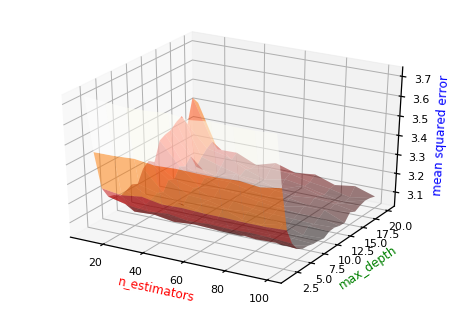

In [33]:
from mpl_toolkits.mplot3d import Axes3D
temp_fig=plt.figure()
temp_ax=Axes3D(temp_fig)
temp_x=np.array(range(10,110,10))
temp_y=np.array(range(1,21))
temp_x, temp_y = np.meshgrid(temp_x, temp_y)
temp_z=np.ones([20,10])
for i in range(len(temp_x)): # number of max_depth
    for j in range(len(temp_x[0])): # number of n_estimators
        temp_ne=temp_x[0][j]
        temp_md=temp_y[i][0]
        temp_df=rfc_score[rfc_score['n_estimators']==temp_ne] 
        temp_df=temp_df[temp_df['max_depth']==temp_md]
        temp_mse=temp_df['mse'].values[0]
        temp_z[i][j]=temp_mse
temp_ax.plot_surface(temp_x, temp_y, temp_z, rstride = 1, cstride = 1, cmap=plt.cm.hot,alpha=0.5)
temp_ax.set_xlabel('n_estimators', color='r')
temp_ax.set_ylabel('max_depth', color='g')
temp_ax.set_zlabel('mean squared error', color='b')
temp_fig.show()

In [34]:
rfc_score_min=min(rfc_score['mse'])
best_ne= rfc_score[rfc_score['mse']==rfc_score_min]['n_estimators'].values[0]
best_md= rfc_score[rfc_score['mse']==rfc_score_min]['max_depth'].values[0]
print('the best n_estimators for the model: '+str(best_ne))
print('the best max_depth for the model: '+str(best_md))

the best n_estimators for the model: 90
the best max_depth for the model: 10


We define function to get the mse metric of selected features training compared with true labels with the method of training random forest regressor with 5-cross-validation.  

In [35]:
def rfr_mse_cv5(features,labels):
    score_sum=0
    k_indices=build_k_indices(labels,5,10)
    for k in range(5):       
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= features.values[temp_train_indice]
        temp_train_labels=labels.values[temp_train_indice]
        temp_valid_features=features.values[temp_valid_indice] 
        temp_valid_labels=labels.values[temp_valid_indice]  
        temp_model =  RandomForestRegressor(n_estimators = best_ne, max_depth=best_md, oob_score = True )
        temp_model.fit(temp_train_features,temp_train_labels)
        temp_valid_pred = temp_model.predict(temp_valid_features)                
        temp_score = mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    return score_sum/5

Upon finishing defining the functions above, we use greedy backward selection to iteratively remove features one by one. Our code creates a dataframe `features_select` with each potential feature of 65 in each row and its corresponding mse, which is initialized as 0.0. A list remove_feature is also defined and initialized empty. Then our code use the `remove_feature` to restore the removed features in each iteration. From the iteration 1 to 65, we choose each of the features remained in the dataframe, and combine the temporary single feature with the removed feature in the `remove_feature` to form a combination of `temp_train_feature`. After fitting them with training labels by random forest regressor, we can get the mse (chosen as main metric) of each remained single feature combined with the features already moved in `remove_feature`. Our code sort the dataframe by mse value on descending order. Then we can remove the one feature with the largest mse value, which is to say, that feature contributing least to the prediction combined with features already removed. And the dataframe updates itself by deleting the first row (corresponding to the feature decided to be removed in this iteration). That feature is also added to `remove_feature` to the next iteration. The iteration is not over until the dataframe `features_select` has the last one feature.The code approach complies to defination of greedy backward selection to remove features one by one. 

In [36]:
features_select = pd.DataFrame({'feature':np.array(train_features.columns),'mse':0.0})
temp_features_select=features_select.copy()
remove_feature=[]
remove_score=[]
while len(temp_features_select)>0:
    for i in range(len(temp_features_select)):
        temp_feature=temp_features_select['feature'].values[i]
        temp_train_feature=remove_feature+ [temp_feature]
        temp_score=rfr_mse_cv5(train_features[temp_train_feature],train_labels)
        temp_features_select['mse'].values[i]= temp_score
    temp_features_select=temp_features_select[['feature','mse']].sort_values(ascending=False, by='mse')
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
    temp_remove_feature=temp_features_select['feature'].values[0]
    temp_remove_score=temp_features_select['mse'].values[0]
    k=len(temp_features_select)
    features_select['feature'].values[65-k]= temp_remove_feature
    remove_feature=remove_feature + [temp_remove_feature]
    remove_score=remove_score+[temp_remove_score]
    temp_features_select=temp_features_select[1:]
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
select_features=remove_feature[::-1]
select_features

['vote_count',
 'popularity',
 'vote_average',
 'Drama',
 'New Line Cinema',
 'United States of America',
 'Twentieth Century Fox Film Corporation',
 'Universal Pictures',
 'Canada',
 'Science Fiction',
 'History',
 'English',
 'title_change',
 'Music',
 'Comedy',
 'Animation',
 'Thriller',
 'War',
 'Romance',
 'Paramount Pictures',
 'Steven Spielberg',
 'Metro-Goldwyn-Mayer (MGM)',
 'Pусский',
 'Horror',
 'Walt Disney Pictures',
 'France',
 'Español',
 'Western',
 'Crime',
 'Italy',
 'Mystery',
 'Woody Allen',
 'Germany',
 'Relativity Media',
 'Columbia Pictures',
 'العربية',
 'Touchstone Pictures',
 'Português',
 'Italiano',
 'Deutsch',
 '日本語',
 'Fantasy',
 'Japan',
 'Australia',
 'Documentary',
 'Spain',
 '普通话',
 'United Kingdom',
 'China',
 'Clint Eastwood',
 'Warner Bros.',
 'Foreign',
 'Family',
 'Robert Rodriguez',
 'Français',
 'Steven Soderbergh',
 'Ridley Scott',
 'Renny Harlin',
 'Martin Scorsese',
 'TV Movie',
 'Spike Lee',
 'Action',
 'Adventure',
 'release_year',
 'runtim

Our main aim is not to create a perfect model for the dataset, but to find the top feautures that affect the movie profit most.
Here we finish the getting the features order in importance for the regression of profit proportion by inversing the order of backward list.In value features, vote and popularity affect the profit most, which conforms to our intuitive assunption. Among non-value features, a profitable movie is mostly influenced by whether a movie is a drama, whether it's produced by companies like New Line Cinema or Twentieth Century Fox Film Corporation or whether it's produced in North America. Relatively, the language and director do not affect the movie profits as much as a company do, since the profit is the company's intenstion for making movies, which also conform to intuitive assumption.

# 4. How to Make a Hit Movie

# 4.1) Non-numeric Data Analysis

To make a hit movie,various features are deserved for detailed analysis, both value and non-value features. Also, for better visualization in this part, we use plotly library to get interactive figures of the relationships, which is also more suitable for later data story. The plotly figure may not been shown in the jupyter notebook, but they can been attatched in the folder named `plotly_image`.

In [4]:
merge_an=merge_raw.copy()
tmdb_data=pd.read_pickle('tmdb_data.pkl')
merge_an=merge_an.groupby('title').mean()
merge_an['title']=merge_an.index
merge_an=merge_an[['title','overall']]
merge_an=pd.merge(merge_an,tmdb_data,on='title')
merge_an.head(1)

,title,overall,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count,director,release_year,profit,title_change
0,11:14,4.185714,"[Henry Thomas, Blake Heron, Barbara Hershey, H...",6000000,"[Crime, Drama, Thriller]","[alcohol, sex, robbery, secret, gun, ambulance...",en,15.048067,"[Firm Films, Media 8 Entertainment, MDP Worldw...","[Canada, United States of America]",0,86.0,[English],6.8,206,Greg Marcks,2003.0,-1.0,1


In [6]:
def get_count(col):
    temp_count = dict()
    for row in col:
        for temp_feature in row:
            if temp_feature in temp_count:
                temp_count[temp_feature] += 1
            else:
                temp_count[temp_feature] = 1
    return temp_count

In [7]:
def get_direcotr_count(col):
    temp_count = dict()
    for temp_director in col:
            if temp_director in temp_count:
                temp_count[temp_director] += 1
            else:
                temp_count[temp_director] = 1
    return temp_count

To make a hit movie, in addtion to simple numbers like budget and popularity, other text information is also informative. In this part we focus on the relationship between Amazon rating and non-value features like movie genres, directors and production companies.

The genres of movies are very informative, for example, in typical years , specific genres of movie tend to lead a fashion, and greatly affect the review, rating and other forms of evluation towards a film. First, an interactive evolution of movie genres is plotted.

In [194]:
genre_list=list(genres_stat.columns)
potantial_color=['#fbb4af','#b3cdea','#ccebcd','#decbea','#fed9a7','#c7eae8','#e5d8bb','#fddaee','#f2f2f7','#fbb4ac','#b3cdea','#ccebc9','#decbe8','#fed9ab','#c7eaee','#e5d8bb','#fddaee','#f2f2f7','#fbb4a7','#b3cdee','#ccebcf','#decbe7','#fed9a5','#c7eae6','#e5d8bc','#fddfa','#f2f2f7','#fbb4ae','#b3cdec','#ccebc7']
temp_line=[]
for ind, genre in enumerate(genre_list):
    temp_line.append(
        go.Scatter(
            x=genres_stat.index,
            y=genres_stat[genre],
            name=genre,legendgroup=genre,
            line = dict(color = (potantial_color[ind]),width = 3),), )
layout = go.Layout( autosize=True, title='Evoluation of Genres through Years',)
fig = go.Figure(data=temp_line,layout=layout)
plot(fig, show_link=False,filename='Evoluation of Genres through Years')
py.iplot(fig,filename='Evoluation of Genres through Years')

The plotly figure is stored in '[plotly_image/Evoluation of Genres through Years.html](plotly_image/Evoluation%20of%20Genres%20through%20Years.html)' on github.

Drama has always been a leading trend in history, followed by comedy and little attention is paid to foreign movies. The trend of other genres have been fluctuating through time and market of movies for that are usually changing.

Intuitvely, a genre will affect the rating and review length of a movie since a hot type will attract more people and arouse their thoughts for more review texts, so average rating and review length of each genre will be analyzed.

In [133]:
merge_an['review_length']=[len(temp_review) for temp_review in merge_an.reviewText]
genres_count = pd.Series(get_count(merge_an['genres']))

We dedine a function to extract the average value of a selected feature for each genre. The function can also be use in later analysis of production countries since they share the same sturcture in the original dataframe.

In [121]:
def get_avg_all(genres_count,genres,rev,merge_an):
    rev_array=[]
    for temp_genre in genres_count.index:
        count=rev_sum=0
        for i in range(len(merge_an)):
            if temp_genre in merge_an[genres].values[i]:
                count=count+1
                temp_rev=merge_an[rev].values[i]
                rev_sum=rev_sum+temp_rev
        if count==0: temp_avg_rev=0
        else: temp_avg_rev=rev_sum/count
        rev_array=rev_array+[temp_avg_rev]
    temp_pd=pd.DataFrame({genres:np.array(genres_count.index),rev:np.array(rev_array)})
    return temp_pd

We use the function to extract the feature values shown below.

In [141]:
merge_an=merge_an.fillna(0)
genre_overall=get_avg_all(genres_count,'genres','overall',merge_an)
genre_pop=get_avg_all(genres_count,'genres','popularity',merge_an)
temp_genre_pd=pd.merge(genre_overall,genre_pop,on='genres')
genre_len=get_avg_all(genres_count,'genres','review_length',merge_an)
temp_genre_pd=pd.merge(temp_genre_pd,genre_len,on='genres')
genre_rev=get_avg_all(genres_count,'genres','revenue',merge_an)
temp_genre_pd=pd.merge(temp_genre_pd,genre_rev,on='genres')
genre_va=get_avg_all(genres_count,'genres','vote_average',merge_an)
genre_pd=pd.merge(temp_genre_pd,genre_va,on='genres')
genre_pd.head(1)

,genres,overall,popularity,review_length,revenue,vote_average
0,Action,3.914473,29.624649,1012.696703,1.078980e+08,6.29199


We use a bar chart and line plot to show the distribution of average rating and review length.

In [231]:
#genre_pd=genre_pd.drop(9,axis=0)
va_fig=go.Bar(
    x=list(genre_pd.genres),
    y=genre_pd.overall.values,
    name='Average Rating',
    marker=go.Marker(color='#b3cde6')
)
len_fig=go.Scatter(
    x=list(genre_pd.genres),
    y=genre_pd.review_length.values,
    name='Average Length of Review', yaxis='y2',line = dict(color = ('#fbb4ac'),width = 3))
data=[va_fig,len_fig]
layout=go.Layout(
    title='Average Rating and Average Length of Review in All Genres',
    titlefont=dict(size=20),
    xaxis=dict(title='Genres' ),
    yaxis=dict(title='Average Rating',showgrid=False, ),
    yaxis2=dict(title='Average Length of Review',overlaying='y',showgrid=False,side='right'),
    legend=dict(orientation="h", x=.7,y=1.1,),)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='genres_rating_vs_review_length')

The plotly figure is stored in '[plotly_image/genres_rating_vs_review_length.html](plotly_image/genres_rating_vs_review_length.html)' on github.

Most genres share the close average rating with Science Fiction rated highest. However, 
Visually there is no direct relationship between average rating and review length among different genres, at leat no linear relationship.

In [152]:
max_pop=max(genre_pd.popularity)
max_rev=max(genre_pd.revenue)
max_va=max(genre_pd.vote_average)
genre_pd['popularity']=genre_pd['popularity']/max_pop
genre_pd['revenue']=genre_pd['revenue']/max_rev
genre_pd['vote_average']=genre_pd['vote_average']/max_va

Also, bar charts of popularity, revenue and average vote are shown. To make the features more visible, we divide each feature by the maximum value in them, thus sharing a same range of (0,1).

In [229]:
potantial_color=['#b3cdee','#fbb4aa','#fed9a7']
data = []
for ind, value in enumerate(['popularity','revenue','vote_average']):
    data.append(
        go.Bar(
            x=list(genre_pd.genres),
            y=genre_pd[value],
            name=value, 
            marker = dict(color = (potantial_color[ind]),
            line = dict(color = (potantial_color[ind]),width = 3), ) )  )
layout = go.Layout(autosize=True,title='Popularity, Revenue and Average for All genres',)
fig = go.Figure(data=data,layout=layout)
py.iplot(fig,filename='Popularity, Revenue and Average for All genres')

The plotly figure is stored in '[plotly_image/genres_popularity_revenue_average.html](plotly_image/genres_popularity_revenue_average.html)' on github.

Director is also an important factor that lead to profit and review. Personally, if James Cameron directs a new movie, I will definitely go to the cinema for it and make my reviews after the payment. It's called the influence of celebrity. Compared with other crew or cast in movie procution, a director is perhaps the most important role in a movie, and we will analyze that.

In [202]:
director_count = pd.Series(get_direcotr_count(merge_an['director'])).sort_values(ascending=False)
director_count=director_count[1:]
director_an_df=pd.DataFrame(director_count)
director_an_df['director']=director_an_df.index
for temp_genres in genres_count.index:
    director_an_df[temp_genres]=0
for temp_overall in [1.0,2.0,3.0,4.0,5.0]:
    director_an_df['overall '+str(temp_overall)]=0

In [210]:
director_an_df[director_an_df.director=='Martin Scorsese']['overall 1.0'].values[0]=1

In [220]:
for temp_director in director_count.index:
    for i in range(len(merge_an)):
        if temp_director==merge_an.director.values[i]:
            temp_overall=merge_an.overall.values[i]
            director_an_df['overall '+str(temp_overall)][temp_director]=director_an_df['overall '+str(temp_overall)][temp_director]+1
            for temp_genre in merge_an.genres[i]:
                director_an_df[temp_genre][temp_director]=director_an_df[temp_genre][temp_director]+1
director_an_df.head(1)

,0,director,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,Science Fiction,TV Movie,Thriller,War,Western,overall 1.0,overall 2.0,overall 3.0,overall 4.0,overall 5.0
Martin Scorsese,1202,Martin Scorsese,1,0,0,0,823,0,1202,0,...,0,0,0,0,0,52,53,90,228,779


By getting the average rating for each director, we get the plot of top 10 directors that participate in most movies and their corresponding average rating.

In [185]:
director_count = pd.Series(get_direcotr_count(merge_an['director'])).sort_values(ascending=False)
director_count=director_count[1:]
director_count_df=pd.DataFrame(director_count)
director_count_df['director']=director_count_df.index
director_count_df['count']=director_count_df[0]
director_count_df.reset_index(inplace=True)
director_count_df=director_count_df[['director','count']]
director_count_df['total_rating']=0
for temp_director in merge_an.director:
    total_merge_temp_director=merge_an[merge_an['director']==temp_director]
    temp_total_rating=total_merge_temp_director.overall.sum()
    temp_index=director_count_df[director_count_df['director']==temp_director].index
    director_count_df.total_rating[temp_index]=total_merge_temp_director.overall.sum()
director_count_df['average_rating']=director_count_df['total_rating']/director_count_df['count']

In [227]:
director_count_df=director_count_df.iloc[:20]
layout = go.Layout(xaxis = dict(tickangle = 30,tickfont = dict(size = 10)),
                  yaxis=dict(type='linear',range=[1, 5],dtick=0.1 ),title='Average Rating for Top 20 Popular Directors')
data = [go.Bar(x=director_count_df.director, y=director_count_df.average_rating,
            marker=dict(
                color=['#fbb4af','#b3cdea','#ccebcd','#decbea','#fed9a7','#c7eae8','#e5d8bb','#fddaee','#f2f2f7','#fbb4ac','#b3cdea','#ccebc9','#decbe8','#fed9ab','#c7eaee','#e5d8bb','#fddaee','#f2f2f7','#fbb4a7','#b3cdee','#ccebcf','#decbe7','#fed9a5','#c7eae6','#e5d8bc','#fddfa','#f2f2f7','#fbb4ae','#b3cdec','#ccebc7']
            ),
            opacity=0.8
        )]
fig = go.Figure(data=data, layout=layout)
#plot(fig, show_link=True,filename='director_rating')
py.iplot(fig,filename='director_rating')

The plotly figure is stored in '[plotly_image/director_rating.html](plotly_image/director_rating.html)' on github.

Since these 10 directors participate in more movies than others, they have their own charms. All of them get a rating over 3.0 and most of them have a rating over 4.0, which can show their ability of directing movies to some degree, making them popular when making a movie.

In [78]:
director_va_profit=pd.merge(director_count_df,merge_an,on='director')
director_va_profit=director_va_profit[['director','average_rating','profit','vote_average']]
director_va_profit.fillna(0)
director_va_profit.head(1)

,director,average_rating,profit,vote_average
0,Martin Scorsese,4.207628,-1.0,6.6


The profit proportion and average vote in TMDB are also calculated for top 10 directors and then plotted.

In [86]:
director_va_profit=director_va_profit.groupby('average_rating').mean()
director_va_profit=director_va_profit.iloc[:10]
director_va_profit=pd.merge(director_count_df,director_va_profit,on='average_rating')
director_va_profit=director_va_profit[['director','average_rating','profit','vote_average']]
director_va_profit.head(2)

,director,average_rating,profit,vote_average
0,Brian De Palma,3.476032,0.837493,6.116667
1,Woody Allen,3.752109,4.734506,6.666667


In [228]:
potantial_color=['#b3cdea','#fbb4af']
data = []
for ind, value in enumerate(['profit','vote_average']):
    data.append(
        go.Bar(
            x=list(director_va_profit.director),
            y=director_va_profit[value],
            name=value, 
            marker = dict(color = (potantial_color[ind]),
            line = dict(color = (potantial_color[ind]),width = 3), ) ))
layout = go.Layout(autosize=True,title='Average Vote and Profit for Top 10 Popular Directors',)
fig = go.Figure(data=data,layout=layout)
#plot(fig, show_link=True,filename='director_vote_average_and_profit_3')
py.iplot(fig,filename='director_vote_average_and_profit_3')

The plotly figure is stored in '[plotly_image/director_vote_average_and_profit_3.html](plotly_image/director_vote_average_and_profit_3.html)' on github.

Those directors are popular for reasons, maybe they do not always make a movie that has a good reputation shown by vote, but they can bring the movie producers profits with great probability. The average profit proportion of these popular directors are all greater than 0, some even reach the profit proportion of 5! From the point of movie producers, they care about relationship between revenue and budget most, which can be shown by the feature value of profit. Thus, making an invitation to popular directors lead to a shorter path for money making.

Production companies of movies also lead to an intuitive thought, since they consist of a whole group of crew. Maybe some of them are not as famous as a hot director, their stable cooperation inside a mutual company will definitely affect the quality of a movie. 

In [166]:
company_count = pd.Series(get_count(merge_an['production_companies']))
company_count = company_count.sort_values(ascending=False) 
company_count=company_count[:10]

We also calculate the average value of several features of 10 production companies that make most movies, since they have a stable number of movie production, and their values avoid a chance of randomness that exist in small companies.

In [170]:
company_overall=get_avg_all(company_count,'production_companies','overall',merge_an)
company_va=get_avg_all(company_count,'production_companies','vote_average',merge_an)
temp_company_pd=pd.merge(company_overall,company_va,on='production_companies')
company_budget=get_avg_all(company_count,'production_companies','budget',merge_an)
temp_company_pd=pd.merge(temp_company_pd,company_budget,on='production_companies')
company_rev=get_avg_all(company_count,'production_companies','revenue',merge_an)
company_pd=pd.merge(temp_company_pd,company_rev,on='production_companies')
company_pd.head(1)

,overall,production_companies,vote_average,budget,revenue
0,4.037447,Warner Bros.,6.583984,5.234810e+07,1.770056e+08


In [184]:
potantial_color=['#b3cdea','#fbb4ba','#fed9af','#cceaff']
data1=data2 = []
for ind, value in enumerate(['budget','revenue']):
    data1.append(
        go.Bar(
            x=list(company_pd.production_companies),
            y=company_pd[value],
            name=value, 
            marker = dict(color = (potantial_color[ind]),
            line = dict(color = (potantial_color[ind]),width = 3), ) )  )
for ind, value in enumerate(['overall','vote_average']):
    data2.append(
        go.Scatter(
            x=list(company_pd.production_companies),
            y=company_pd[value],
            yaxis='y2',
            name=value,legendgroup=value,
            line = dict(color = (potantial_color[2+ind]),width = 3),), )
layout = go.Layout(autosize=True,    
                   xaxis=dict(title='Companies' ),
                   yaxis=dict(title='Money in Budget or Revenue',showgrid=False, ),
                   yaxis2=dict(title='Average Rating or Vote',overlaying='y',showgrid=False,side='right'),
                   legend=dict(orientation="h", x=.7,y=1.1,),)
data=[data1,data2]
fig = go.Figure(data=data2,layout=layout)
py.iplot(fig, filename='Distribution for Top 10 Movie Companies')

The plotly figure is stored in '[plotly_image/Distribution for Top 10 Movie Companies.html](plotly_image/Distribution%20for%20Top%2010%20Movie%20Companies.html)' on github.

Large companies always lead to high revenue and high budget-to-revenue ratio as well. The top movie-maker company Warner Bros. lead to the highest average revenue, and making its role in the market of movie making. Also it seems that rating and vote have the same trend among these companies, since the shape of line plots are similar.

So far we finish the analysis of most intuitive non-value features like genres, directors and production countries. They all help us discover some interesting things, and especially they show the correlation between Amazon rating and TMDB vote, they seem to have a close relationship with each other. Later we will focus on the analysis of value featurs, using mathematical stastical method as well as machine learning algorithms. Also, though the above analysis does not show a causal relationship between review length and rating, intuitively they have a strong relationship between each other, and we will use text propessing method to deeper analyze the inside text features of the reviews.

In [2]:
merge_raw=pd.read_pickle('merge_raw.pkl')
merge_geo=merge_raw.copy()
#merge_geo=merge_geo.groupby('title','production_countries').mean()
merge_geo.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,asin,reviewText,reviewerName,helpful,summary,overall,reviewerID,unixReviewTime,reviewTime
0,The Chronicles of Narnia: Prince Caspian,"[Ben Barnes, William Moseley, Anna Popplewell,...",225000000,"[Adventure, Family, Fantasy]","[based on novel, fictional place, brother sist...",en,53.978602,"[Walt Disney, Walden Media, Stillking Films, O...","[Czech Republic, Poland, Slovenia, United Stat...",419651413,...,"{'also_bought': ['B004M1A21K', 'B000E8M0VA', '...",B00005JPH2,Highly recommended for parents and children. ...,"1gewehr ""1gewehr""","[0, 0]",Lots of action and adventure,4.0,A2FI56P3ZSOUWG,1377043200,"08 21, 2013"


We try to analyze the rating and related feature from the point of geographic distribution. We can get the sum of rating and the number of movies each country in the dataset has participated in, and get the dataframe.

In [4]:
country_count = pd.Series(get_count(merge_raw['production_countries']))
ratings_array=[]
sf_array=[]
for temp_country in country_count.index:
    temp_count=0
    temp_sf_count=0
    temp_rating_sum=0
    sf_rating_sum=0
    for i in range(len(merge_geo)):
        if temp_country in merge_geo['production_countries'].values[i]:
            temp_rating_sum=temp_rating_sum+merge_geo.overall.values[i]
            temp_count=temp_count+1
            if 'Comedy' in merge_geo.genres.values[i]:
                sf_rating_sum=sf_rating_sum+merge_geo.overall.values[i]
                temp_sf_count=temp_sf_count+1
    temp_country_rating=temp_rating_sum/temp_count
    if temp_sf_count==0:
        sf_country_rating=0
    else:
        sf_country_rating=sf_rating_sum/temp_sf_count
    ratings_array=ratings_array+[temp_country_rating]
    sf_array=sf_array+[sf_country_rating]
country_ratings = pd.DataFrame({'Country':np.array(country_count.index),'overall_rating':np.array(ratings_array),
                                'comedy_rating':np.array(sf_array)})
country_ratings.tail()

,Country,comedy_rating,overall_rating
0,Afghanistan,0.0,4.528571
1,Argentina,0.0,3.427350
2,Aruba,0.0,3.321429


Since there is only country name in the dataset without accurate Latitude or Longitude, we find a file online that could correspond the country name to its centroid coordinations. We read the csv file and use country name to merge it with our previous dataframe.

In [24]:
geo_info=pd.read_csv('data/geolocations.csv')
loc_ratings=pd.merge(country_ratings,geo_info,on='Country')
loc_ratings.head(1)

,Country,comedy_rating,overall_rating,ISO 3166 Country Code,Latitude,Longitude
0,Afghanistan,0.0,4.528571,AF,33.0,65.0


In [25]:
heat_data=[]
for i in range(len(loc_ratings)):
    temp_lat=loc_ratings.Latitude.values[i]
    temp_lon=loc_ratings.Longitude.values[i]
    temp_ratings=loc_ratings.overall_rating.values[i]
    temp_heat_data=[temp_lat,temp_lon,temp_ratings]
    heat_data=heat_data+[temp_heat_data]

We use folium to visualize the geoprahic distribution in maps.Heatmap is used to centralized distribution of movie-produced counntries in global map, with corresponding rating values.

In [31]:
import folium
from folium.plugins import HeatMap
m = folium.Map([ 0, 0], tiles='stamentoner', zoom_start=2)
HeatMap(heat_data).add_to(m)
m.save('images/Overall_Distribution_with_Heatmap.html')
display(m)

The map is stored in '[maps/Overall_Distribution_with_Heatmap.html](maps/Overall_Distribution_with_Heatmap.html)' on github.

From the heatmap, we can oberve the movies in the dataset have a concentrated distribution in east and middle Europe, America and east Asia

And we now focus on the rating ditribution, we use a circle to represent for the average rating of a country, the larger the radiums of the circle, the higher average rating a country gets.

In [32]:
m1 = folium.Map(location=[0,0], zoom_start=2)
for i in range(len(loc_ratings)):
    folium.Circle(
      location=[loc_ratings.iloc[i]['Latitude'], loc_ratings.iloc[i]['Longitude']],
      popup=loc_ratings.iloc[i]['ISO 3166 Country Code'],
      radius=loc_ratings.iloc[i]['overall_rating']*80000,
      color='blue',
      fill=True,
      fill_color='blue'
      ).add_to(m1)
m1.save('images/Overall_Ratings_with_Circles.html')
display(m1)

The map is stored in '[maps/Overall_Ratings_with_Circles.html](maps/Overall_Ratings_with_Circles.html)' on github.

Larger circles exist in north Eruope and noth America, which means the ratings are visually higher in these areas than the other part of the world.

To make the rating distribution clearer, we use the choropleth in folium, thus using color in the country borders to represent for the average rating of the country. Also we get a file that relates each potential country name with corresponding detailed border coordinates.

To give the white color to the countries that do not participate any film in our merged dataset, otherwise it will be represented by the deepest color. We fill the area in each country border with the color related to its average rating value.

In [36]:
nan_handle_function = lambda data: {'fillColor':'#ffffff',
                                    'fillOpacity': '1' if (data['features']['properties']['name'] in loc_ratings.Country.values )==False
                                    else '0'}

In [37]:
geo_border = json.load(open('countries_borders.geo.json'))
m.choropleth(geo_data=geo_border, data=country_ratings,
             columns=['Country', 'overall_rating'],
             key_on='feature.properties.name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Geographic Distribution of Overall Movie Ratings')

In [38]:
folium.TopoJson(
    geo_border,
    'feature.properties.name',
    style_function=nan_handle_function,
    control=False
).add_to(m)

m.save('images/Overall_Ratings_with_Heatmap.html')
display(m)

The map is stored in '[maps/Overall_Ratings_with_Heatmap.html](maps/Overall_Ratings_with_Heatmap.html) on github.

The average of ratings for all movies in each country is shown above, most areas have an average rating of about 3.5, and the average is especially higher in Europe, east Asia, north Africa, North America and India through the global map.

Now by focusing on the average rating of comedy movies and get the map again to visualize the geographic distribution of comedy movies.

In [46]:
md = folium.Map([ 0, 0], tiles='stamentoner', zoom_start=2)
heat_data=[]
for i in range(len(loc_ratings)):
    temp_lat=loc_ratings.Latitude.values[i]
    temp_lon=loc_ratings.Longitude.values[i]
    temp_ratings=loc_ratings.comedy_rating.values[i]
    temp_heat_data=[temp_lat,temp_lon,temp_ratings]
    heat_data=heat_data+[temp_heat_data]
HeatMap(heat_data).add_to(md)
md.choropleth(geo_data=geo_border, data=country_ratings,
             columns=['Country', 'comedy_rating'],
             key_on='feature.properties.name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Geographic Distribution of Comedy Ratings')
folium.TopoJson(
    geo_border,
    'feature.properties.name',
    style_function=nan_handle_function,
    control=False
).add_to(md)
md.save('images/Comedy_Ratings_with_Heatmap.html')
display(md)

The map is stored in '[maps/Comedy_Ratings_with_Heatmap.html](maps/Comedy_Ratings_with_Heatmap.html)' on github.

Most countries have the similar average rating with all movies, and it can be understood that most countries develop each genre of movies with same efforts. However,colors become obviously lighter in China, Russia and South America, there areas are not good at making people laugh compared with other countries.

# 4.2) Numeric Data Analysis

Now, we begin to do some numeric analysis on the two datasets to see the correlation between factors.

### Amazon/TMDB rating vs Profit/Revenue

We analyse the correlation between ratings and profit/revenue. We generate a corresponding dataframe for further analysis.

In [69]:
# get data
merge_group = merge_raw[['title', 'budget', 'revenue', 'profit', 'vote_average','overall']].groupby(['title'])
merge_group_averaged = merge_group.mean()
merge_group_averaged.head()

,budget,revenue,profit,vote_average,overall
title,,,,,
11:14,6000000,0,-1.000000,6.8,4.185714
1408,25000000,94679598,2.787184,6.5,3.726190
"20,000 Leagues Under the Sea",5000000,28200000,4.640000,6.8,2.863636
2016: Obama's America,2500000,33400000,12.360000,4.6,3.957207
2046,12000000,19271312,0.605943,6.9,3.901961


In the two datasets(Amazon and TMDB), we have two different ratings for a certain movie. One is from Amazon reviewers, which is a rating from 1 to 5 given on the movie products from Amazon. The other is from TMDB users, who usually should be movie fans who give a rating from 1 to 10 to the movies. What is the relation between these two ratings? We compared the two average ratings on each movie and made a scatter plot:

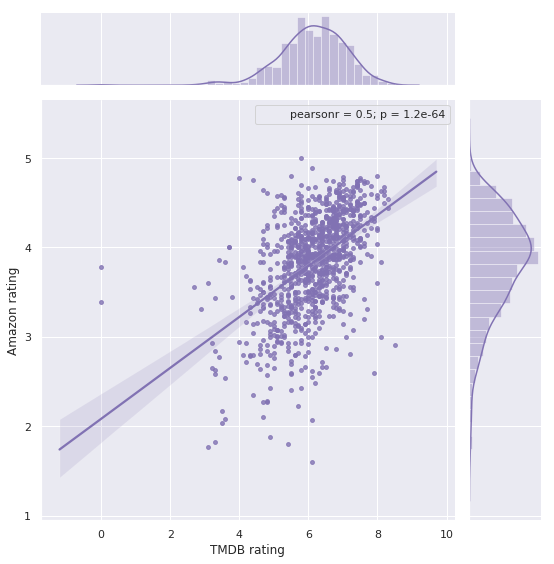

In [237]:
# plot tmdb rating and amazon rating
sns.set(style="darkgrid")
g = sns.jointplot("vote_average", "overall", data=merge_group_averaged, 
                  kind="reg", color="m", height=8, scatter_kws={"s": 15})
g.set_axis_labels('TMDB rating', 'Amazon rating')
g.annotate(sp.stats.pearsonr)
g.savefig('tmdb-amazon.png')

We noticed a moderate positive correlation (~0.5) between TMDB and Amazon rating. This means the ratings on the two platforms are overall consistent.

We are also interested in how budget and revenue of a movie correlates with its rating. Does high budget always lead to a blockbuster? We made a scatter plot for these three factors.

There are some zeros in budget or revenue which should mean NAN, and these entries should be removed in this section.

In [72]:
# remove zeros
merge_group_profit = merge_group_averaged[(merge_group_averaged['budget']!=0)\
                                            & (merge_group_averaged['revenue']!=0)]

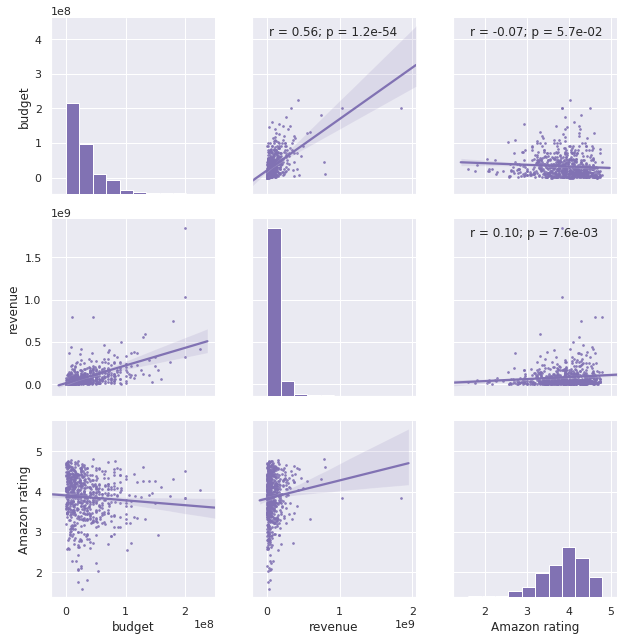

In [253]:
# plot correlation of budget/revenue/rating
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}; p = {:.1e}".format(r, p),
                xy=(.1, .9), xycoords=ax.transAxes)

sns.set(style="darkgrid")
g = sns.PairGrid(merge_group_profit[['budget','revenue','overall']], height=3)
g = g.map_diag(plt.hist, color="m")
g = g.map_offdiag(sns.regplot, color="m", scatter_kws={"s": 3})
g = g.map_upper(corrfunc)
g.axes[2,0].yaxis.set_label_text('Amazon rating')
g.axes[2,2].xaxis.set_label_text('Amazon rating')
g.savefig('budget-revenue-rating.png')

Do high budgets correlate with high ratings? No. There is a very weak negative correlation between budget and rating, so spending a lot of money doesn’t always makes a high-rating movie.

Do high revenues correlate with high ratings? Not really. The positive correlation is rather weak. So we can’t tell if a highest grossing movie can get good reputation.

And how about the relation between budgets and revenues? We noticed a moderate positive correlation between these two factors. Maybe movies are a kind of investment where you are able to get high returns with high budgets.

### Helpfulness Analysis

Now we focus on the review itself. We noticed there is a helpfulness vote for each review in the Amazon data. We are curious about what correlation it has with other factors.

First Delete entries whose helpfulness = 0/0. Turn the two integers into a fraction.

In [140]:
# get helpfulness data
merge_helpful = merge_review[merge_review['helpful'].apply(lambda x:x[1]!=0)]
merge_helpful['helpful'] = merge_helpful['helpful'].apply(lambda x:x[0]/x[1])

In [143]:
merge_helpful['helpful'].describe()

count    77378.000000
mean         0.574630
std          0.358199
min          0.000000
25%          0.303030
50%          0.600000
75%          1.000000
max          2.000000
Name: helpful, dtype: float64

There are dirty data where helpfulness rating > 1. We delete these eentries.

In [144]:
merge_helpful = merge_helpful[merge_helpful['helpful']<1.0001]

In [419]:
merge_helpful.to_pickle('merge_helpful.pkl')

We group the reviews by reviewer to see the difference between each reviewer.

In [381]:
# review groupby reviewer
merge_reviewer_helpful = merge_helpful.groupby(['reviewerID'])
merge_reviewer_helpful['title'].count().value_counts().head()

1    17817
2     5232
3     2134
4     1062
5      640
Name: title, dtype: int64

Many reviewers only have one review. We'd like to count the reviews and see the distribution of the number of reviews.

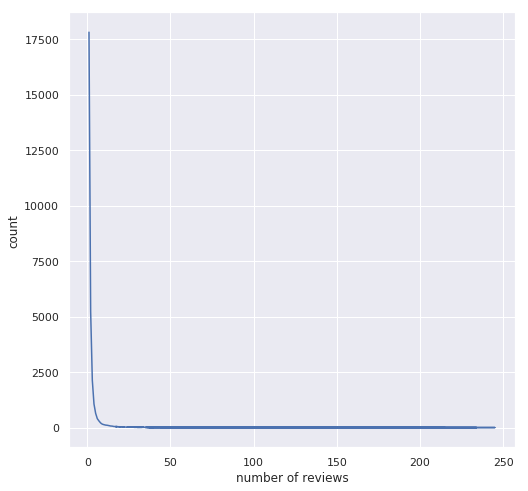

In [374]:
# review count distribution
plt.figure(figsize=(8,8))
plt.plot(merge_reviewer_helpful['title'].count().value_counts())
plt.xlabel('number of reviews')
plt.ylabel('count')
plt.savefig('review_count.png')

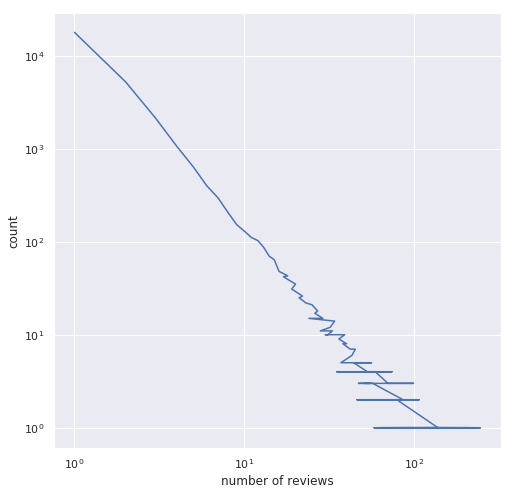

In [375]:
# log-log plot for review count distribution
plt.figure(figsize=(8,8))
plt.plot(merge_reviewer_helpful['title'].count().value_counts())
plt.xlabel('number of reviews')
plt.ylabel('count')
plt.xscale('log')
plt.yscale('log')
plt.savefig('review_count_loglog.png')

The number of reviews of each reviewer appoximately follows the power law. After this, we want to know how a reviewer's averaged performence is on rating, helpfulness and sentiment score. The sentiment score is what we get by NLP analysis in the next section(Review Text Analysis).

In [156]:
# average helpfulness and sentiment score
merge_reviewer_mean = merge_reviewer_helpful.mean()
merge_reviewer_mean.head()

,helpful,overall,positive,compound
reviewerID,,,,
A00700212KB3K0MVESPIY,1.0,5.0,0.407000,0.966600
A01174011QPNX7GZF4B92,1.0,4.0,0.280000,0.824700
A02296971ID4CDE9LRKK2,1.0,5.0,0.341000,0.822500
A027352438IKKXEMOGF7G,0.0,5.0,0.046000,-0.940800
A02755422E9NI29TCQ5W3,0.0,5.0,0.492333,0.951233


Then we plot the correlation between the average rating, average helpfulness and average sentiment score of each reviewer.

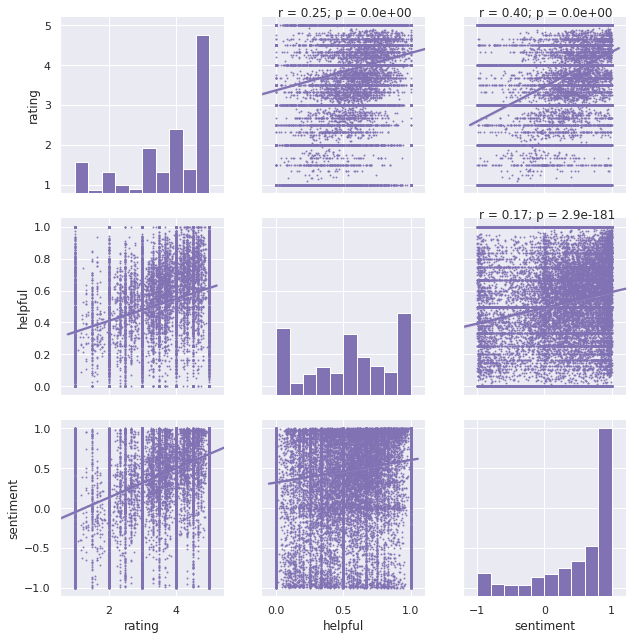

In [380]:
# plot correlation of rating, helpful, sentiment
def corrfunc(x, y, **kws):
    r, p = sp.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}; p = {:.1e}".format(r, p),
                xy=(.1, 1), xycoords=ax.transAxes)

g = sns.PairGrid(merge_reviewer_mean[['overall','helpful','compound']], height=3)
g = g.map_diag(plt.hist, color="m")
g = g.map_offdiag(sns.regplot, color="m", scatter_kws={"s": 1})
g = g.map_upper(corrfunc)
g.axes[2,0].yaxis.set_label_text('sentiment')
g.axes[2,2].xaxis.set_label_text('sentiment')
g.axes[0,0].yaxis.set_label_text('rating')
g.axes[2,0].xaxis.set_label_text('rating')
g.savefig('rating-helpful-sentiment2.png')

We see there are positive correlations between each pair of factors - positive sentiment, high rating, and helpful review.

# 4.3) Review Text Analysis

Now we turn to the analysis of reviews, which is mainly determined by text processing.
Firstly, we use wordcloud to take a glance at the keyword in the review text.

### Some wordcloud

We import the library wordcloud.

In [57]:
from wordcloud import *
import matplotlib.pyplot as plt
import imageio

We define a function to get the word in the review of the type we desire to analyze.

In [58]:
merge_key=merge_raw.copy()
def get_review(genre,temp_genre):
    review_sum=''
    for i in range(len(merge_key)):
        if temp_genre in str(merge_key[genre].values[i]):
            temp_review=merge_key.reviewText.values[i]
            review_sum=review_sum + temp_review+' '
    return review_sum

Not all the words in the review are useful, so another function is defined to delete the useless words and store other words into wordcloud. Fianlly, the function helps to plot a figure with required background mask by the useful keywords it stores.

In [59]:
def show_word(temp_review,mask_name,temp_title):
    del_word = ['movie','film','look','see','seen','must','said','feel','want','make','something','audience','get','either','never','though',
            'yet','guy','one','time','even','will','really','made','now','us','DVD','say','know','come']
    stopword = STOPWORDS|set(del_word)
    temp_mask=imageio.imread('mask/'+mask_name+'_mask.jpg')
    temp_wc = WordCloud(background_color='white',mask=temp_mask,colormap="Set2_r",
                      stopwords=stopword,max_words=2000,max_font_size=200,random_state=30).generate(temp_review)
    temp_fig=plt.figure(figsize=(12, 8))
    plt.imshow(temp_wc)
    plt.title(temp_title) 
    plt.axis('off')
    plt.show()

We get the review keywords of science fiction and animation movies from defined function. Also, we get the keywords of movies rated 1.0 and 5.0.

In [60]:
sf_review=get_review('genres','Science Fiction')
anm_review=get_review('genres','Animation')
rating_5_review=get_review('overall','5.0')
rating_1_review=get_review('overall','1.0')

We can visualize the keywords of science fiction movies and animation movies with the masks of Transformers and Pikachu.

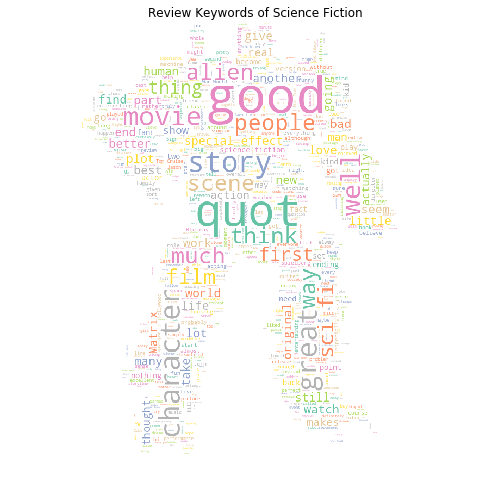

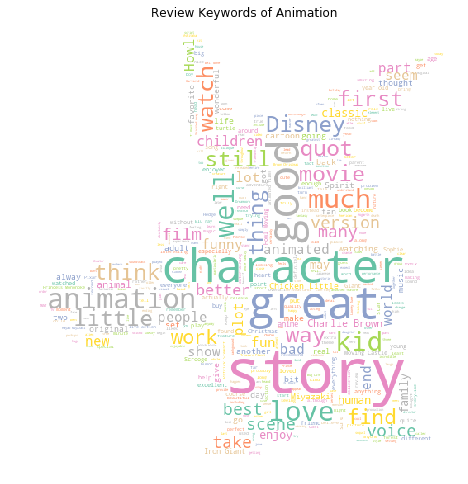

In [61]:
show_word(sf_review,'science_fiction','Review Keywords of Science Fiction')
show_word(anm_review,'animation', 'Review Keywords of Animation')

Also, review keywords of movies rated 1 and 5 can be visualized with the mask of thumb up and thumb down.

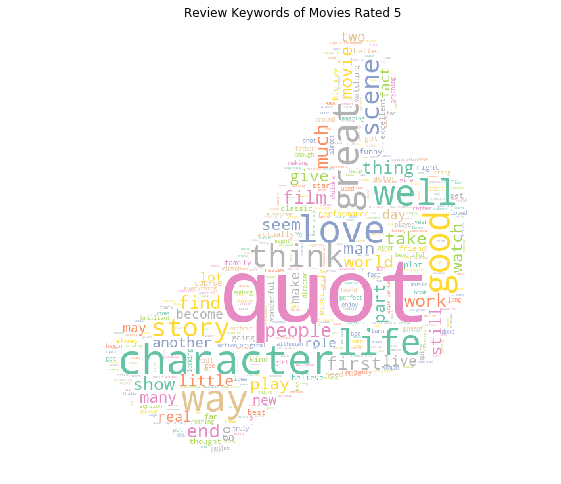

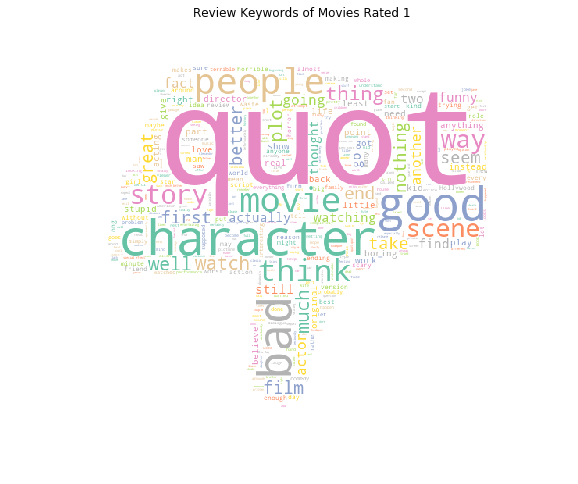

In [62]:
show_word(rating_5_review,'5','Review Keywords of Movies Rated 5')
show_word(rating_1_review,'1','Review Keywords of Movies Rated 1')

Well, from the visualization of review keywords, there are differnt specific words in specific genres (alien in science fiction and disney in in animation).
However, overall it's hard to determine the features of different reviews since mostly they contain similar words and we can not judge a review from the simple wordcloud figures. So later we will focus on more detailed text processing tools, nltk and make analysis inside the correlation between review text.

Since we have a large dataset of review texts, it’s necessary for us to apply some NLP methods on the texts.

### Sentiment Analysis

In [110]:
#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from collections import Counter

We have done sentiment analysis on each review text and got the corresponding positive, negative, neutral and compound scores.

In [114]:
merge_review = merge_raw[['title', 'reviewText', 'helpful', 'summary', 'overall','reviewerID']]

In [119]:
# sentiment analysis for each review
# it takes about 1 hour
analyzer = SentimentIntensityAnalyzer()
merge_review['positive'] = merge_review['reviewText'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
merge_review['negative'] = merge_review['reviewText'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
merge_review['neutral'] = merge_review['reviewText'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
merge_review['compound'] = merge_review['reviewText'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [400]:
merge_review.head()

,title,reviewText,helpful,summary,overall,reviewerID,positive,compound,negative,neutral
0,The Chronicles of Narnia: Prince Caspian,Highly recommended for parents and children. ...,"[0, 0]",Lots of action and adventure,4.0,A2FI56P3ZSOUWG,0.228,0.4576,0.112,0.659
1,The Chronicles of Narnia: Prince Caspian,All these movies are great i wish more would b...,"[0, 0]",Very good,5.0,A2GGB5O6W6D8QN,0.510,0.9490,0.000,0.490
2,The Chronicles of Narnia: Prince Caspian,There are probably two camps who will be inter...,"[16, 18]","""Things Never Happen the Same Way Twice"" [Even...",4.0,A3EE0H0NWQ9QVL,0.072,-0.9583,0.115,0.813
3,The Chronicles of Narnia: Prince Caspian,"I've bought all three Narnia movies, just this...","[0, 0]","Don't know how it compares to book, visually g...",3.0,A3DGB4HN3QCGAL,0.238,0.9418,0.000,0.762
4,The Chronicles of Narnia: Prince Caspian,"November 4th, 2009I don't think it's a big dea...","[0, 0]","A more violent, but still enjoyable effort.",3.0,AMP7TQRWAIE84,0.116,0.3789,0.105,0.779


We calculated the average score for each rating group (from 1 to 5) to see what is the difference in sentiment of reviews with different ratings.

In [401]:
# calculate avegage sentiment for rating=1 to 5
rating_sentiment = merge_review[['overall','positive','negative','neutral','compound']].groupby('overall').mean()
rating_sentiment

,positive,negative,neutral,compound
overall,,,,
1.0,0.111627,0.135872,0.752503,-0.134861
2.0,0.127866,0.108957,0.763174,0.153081
3.0,0.151662,0.085977,0.762357,0.431127
4.0,0.178525,0.073171,0.748302,0.579377
5.0,0.206451,0.061152,0.732394,0.646197


In [403]:
# plot sentiment of reviews with different ratings
trace1 = go.Scatter(
    x = rating_sentiment.index,
    y = rating_sentiment['positive'],
    mode = 'lines+markers',
    name = 'Positive sentiment'
)

trace2 = go.Scatter(
    x = rating_sentiment.index,
    y = rating_sentiment['negative'],
    mode = 'lines+markers',
    name = 'Negative sentiment'
)

trace3 = go.Scatter(
    x = rating_sentiment.index,
    y = rating_sentiment['neutral'],
    mode = 'lines+markers',
    name = 'Neutral sentiment'
)

trace4 = go.Scatter(
    x = rating_sentiment.index,
    y = rating_sentiment['compound'],
    mode = 'lines+markers',
    name = 'Compound sentiment'
)

data = [trace1, trace2, trace3, trace4]

layout = dict(title = 'Sentiment of reviews with different ratings',
              xaxis = dict(title = 'Review rating'),
              yaxis = dict(title = 'Averaged sentiment score'),
              )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='rating-sentiment')

The plot generated by plotly can be accessed by this [link](https://plot.ly/~jeffliu/4/sentiment-of-reviews-with-different-ratings/).

We see a clear relation between rating and the sentiment of reviews. As the rating increse, the sentiment of the reviews are likely to be positive.

### Part-of-speech tagging

We’ve tagged every word in the review texts with its part of speech(POS). We used spacy for POS tagging.

In [168]:
nlp = spacy.load('en')
POS = [[] for i in range(5)]

In [383]:
# POS tagging for each word in review texts
# it takes about 2 hours
merge_review.apply(lambda x:POS[int(x['overall'])-1]\
                   .extend([token.pos_ for token in nlp(x['reviewText'])]),axis=1)

In [205]:
pd.Series(POS).to_pickle('POS.pkl')

We would like to know if all the POS tags have the same occurrence rate in each rating group. First we count the occurence of each POS tag in each rating group.

In [229]:
# count POS tags for each rating group
POS_cnt = [pd.DataFrame.from_dict(Counter(POS[i]),orient='index').\
           transpose().rename(index={0:i+1}) for i in range(5)]
POS_cnt_merge = pd.concat(POS_cnt)
POS_cnt_merge.to_pickle('POS_cnt_merge.pkl')
POS_cnt_merge

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB,X
1,148128,157652,123120,55235,164009,4855,276402,15672,41059,91484,81661,202409,26578,1571,282042,773
2,190688,200711,155498,72290,206975,4890,345383,18190,52498,104290,112868,251665,33307,1950,338540,887
3,341991,363291,264231,130358,367058,6746,616350,32633,92023,180955,216135,441692,55178,3582,586715,1426
4,617284,655373,432994,234635,651999,9718,1116829,58302,158747,308861,409561,772628,98950,6576,1012571,2367
5,900955,955106,622887,347599,957946,14270,1639837,92248,220344,485208,605273,1134345,148713,9440,1504550,3661


We normalized the occurence of a POS tag in a rating group by the total count of words in that group, and then calculated the distribution of each POS tag.

In [314]:
# divide by total sum to get percentage
POS_percent = (POS_cnt_merge.T/POS_cnt_merge.sum(axis=1)).T
POS_percent = POS_percent/POS_percent.sum()
POS_percent = POS_percent.drop(columns=['X'])
POS_percent

,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SPACE,SYM,VERB
1,0.192558,0.193306,0.210233,0.189008,0.198016,0.289424,0.197273,0.206557,0.201828,0.217927,0.170380,0.202902,0.205643,0.194725,0.210829
2,0.198324,0.196899,0.212435,0.197912,0.199930,0.233228,0.197222,0.191812,0.206464,0.198764,0.188410,0.201840,0.206184,0.193379,0.202467
3,0.200956,0.201354,0.203947,0.201634,0.200322,0.181782,0.198845,0.194416,0.204471,0.194849,0.203840,0.200142,0.192983,0.200693,0.198246
4,0.204997,0.205291,0.188882,0.205114,0.201102,0.147999,0.203634,0.196307,0.199350,0.187960,0.218303,0.197863,0.195589,0.208230,0.193365
5,0.203165,0.203150,0.184503,0.206331,0.200630,0.147567,0.203025,0.210908,0.187887,0.200500,0.219067,0.197253,0.199601,0.202973,0.195094


See the standard deviation of the distribution.

In [408]:
# calculate std
POS_sorted = np.std(POS_percent).sort_values(ascending=False)
POS_sorted

INTJ     0.054564
PROPN    0.018574
ADV      0.011302
PRON     0.009946
NUM      0.007400
PART     0.006516
VERB     0.006237
CCONJ    0.006230
SYM      0.005454
SPACE    0.005272
ADP      0.004340
ADJ      0.004338
NOUN     0.002787
PUNCT    0.002188
DET      0.001063
dtype: float64

Suppose a POS tag is uniformly distributed in each group, its percentage in each group should be about 20%. We made the boxplot of occurrence rate for each POS tag and the results are as follows:

In [416]:
# plot POS tag distribution in each group
traces = []
for xd in POS_sorted.index:
    traces.append(go.Box(y=POS_percent[xd],name=xd,boxpoints='all',jitter=0.5,
                whiskerwidth=0.2,marker=dict(size=2),line=dict(width=1)))
layout = dict(title = 'Distribution of each POS tag')
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig,filename='POS-dist')

The plot generated by plotly can be accessed by this [link](https://plot.ly/~jeffliu/6/distribution-of-each-pos-tag/).

There are some POS tags with a high variance. We choose the three POS tags with the highest variance - [INTJ](http://universaldependencies.org/u/pos/all.html#al-u-pos/INTJ)(interjection), [PROPN](http://universaldependencies.org/u/pos/all.html#al-u-pos/PROPN)(proper noun), [ADV](http://universaldependencies.org/u/pos/all.html#al-u-pos/ADV)(adverb), and see how their occurence is different in each rating group.

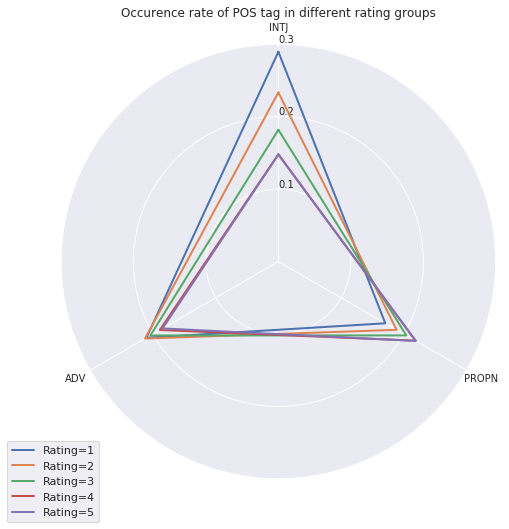

In [417]:
from math import pi
 
sns.set(style='darkgrid')

plt.figure(figsize=(8,8))
categories = ['INTJ', 'PROPN', 'ADV']
df_plot = POS_percent[categories]

angles = [n / 3 * 2 * pi for n in range(3)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, fontsize='small')
ax.set_rlabel_position(0)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.yticks([0.1,0.2,0.3], fontsize='small')
plt.ylim(0,0.3)


for i in range(1,6):
    values=df_plot.loc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label="Rating="+str(i))
    
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Occurence rate of POS tag in different rating groups')
plt.savefig('POS-tagging.png')

The distribution in rating=4 and rating=5 nearly overlap with each other. Apart from this, as the rating goes down, the occurence of INTJ and ADV is increasing, and the occurence of PROPN is decreasing. Maybe the reviewers who give a high rating are likely to talk about the movies, directors and actors (both are proper nouns) while the reviewers who give a low rating like using interjections and adverbs to express their bad feelings. The difference in INTJ is rather clear - more interjections in the negative reviews.

# 4.4) Rating Regression Analysis by Machine Learning

We plan to implement a machine learning analysis in merged data of Amazon rate and TMDB features. We wish to analyze the average rate as the output for regression. Firstly, we choose the best hyperparameters for the whole training sets by cross validation and grid search. Then we use greedy selection to choose the top features that affect the ratings by corss vailadation.By machine learning, we can get the top features that affect Amazon ratings.

In [40]:
merge_raw=pd.read_pickle('merge_raw.pkl')
merge_ml=merge_raw.copy()
merge_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,asin,reviewText,reviewerName,helpful,summary,overall,reviewerID,unixReviewTime,reviewTime
0,The Chronicles of Narnia: Prince Caspian,"[Ben Barnes, William Moseley, Anna Popplewell,...",225000000,"[Adventure, Family, Fantasy]","[based on novel, fictional place, brother sist...",en,53.978602,"[Walt Disney, Walden Media, Stillking Films, O...","[Czech Republic, Poland, Slovenia, United Stat...",419651413,...,"{'bought_together': ['B000E8M0VA', 'B004M1A21K...",B00005JPH2,Highly recommended for parents and children. ...,"1gewehr ""1gewehr""","[0, 0]",Lots of action and adventure,4.0,A2FI56P3ZSOUWG,1377043200,"08 21, 2013"


We treat it as a regression problem. Compard with TMDB data, we require different features. In this step, we turn tget the year values of column reviewTime and create other value features.

In [41]:
merge_ml=merge_raw.copy()
merge_ml.overall= [int(temp_overall) for temp_overall in merge_ml.overall]
merge_ml.reviewTime=[int(temp_review_time[-4:]) for temp_review_time in merge_ml.reviewTime]
merge_ml.head(1)

,title,cast,budget,genres,keywords,original_language,popularity,production_companies,production_countries,revenue,...,related,asin,reviewText,reviewerName,helpful,summary,overall,reviewerID,unixReviewTime,reviewTime
0,The Chronicles of Narnia: Prince Caspian,"[Ben Barnes, William Moseley, Anna Popplewell,...",225000000,"[Adventure, Family, Fantasy]","[based on novel, fictional place, brother sist...",en,53.978602,"[Walt Disney, Walden Media, Stillking Films, O...","[Czech Republic, Poland, Slovenia, United Stat...",419651413,...,"{'bought_together': ['B000E8M0VA', 'B004M1A21K...",B00005JPH2,Highly recommended for parents and children. ...,"1gewehr ""1gewehr""","[0, 0]",Lots of action and adventure,4,A2FI56P3ZSOUWG,1377043200,2013


We choose the following features as the digit features. Compared with previous regression, we need more features like budget, revenue, reviewTime and prodcution companies. We choose the overall we get as the labels for later regression.

In [42]:
merge_ml['summary_length']=[len(temp_summary) for temp_summary in merge_ml.summary]
merge_ml['review_length']=[len(temp_review) for temp_review in merge_ml.reviewText]
merge_ml['helpful_1']=[temp_helpful[0] for temp_helpful in merge_ml.helpful]
merge_ml['helpful_2']=[temp_helpful[1] for temp_helpful in merge_ml.helpful]

In [43]:
merge_ml.profit[merge_ml.profit>10]=10
merge_ml=merge_ml.fillna(0)
merge_ml=merge_ml.groupby('title').mean()
merge_ml.head(2)

,budget,popularity,revenue,runtime,vote_average,vote_count,release_year,profit,title_change,salesRank,price,overall,unixReviewTime,reviewTime,summary_length,review_length,helpful_1,helpful_2
title,,,,,,,,,,,,,,,,,,
11:14,6000000.0,15.048067,0.0,86.0,6.8,206.0,2003.0,-1.000000,1.0,75977.0,5.00,4.185714,1.222244e+09,2008.20000,26.985714,1049.342857,2.957143,4.685714
1408,25000000.0,35.169779,94679598.0,104.0,6.5,1343.0,2007.0,2.787184,1.0,1100028.0,2.99,3.726190,1.257872e+09,2009.31746,29.777778,1149.976190,3.448413,5.119048


In [44]:
merge_ml.columns

Index(['budget', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'release_year', 'profit', 'title_change', 'salesRank',
       'price', 'overall', 'unixReviewTime', 'reviewTime', 'summary_length',
       'review_length', 'helpful_1', 'helpful_2'],
      dtype='object')

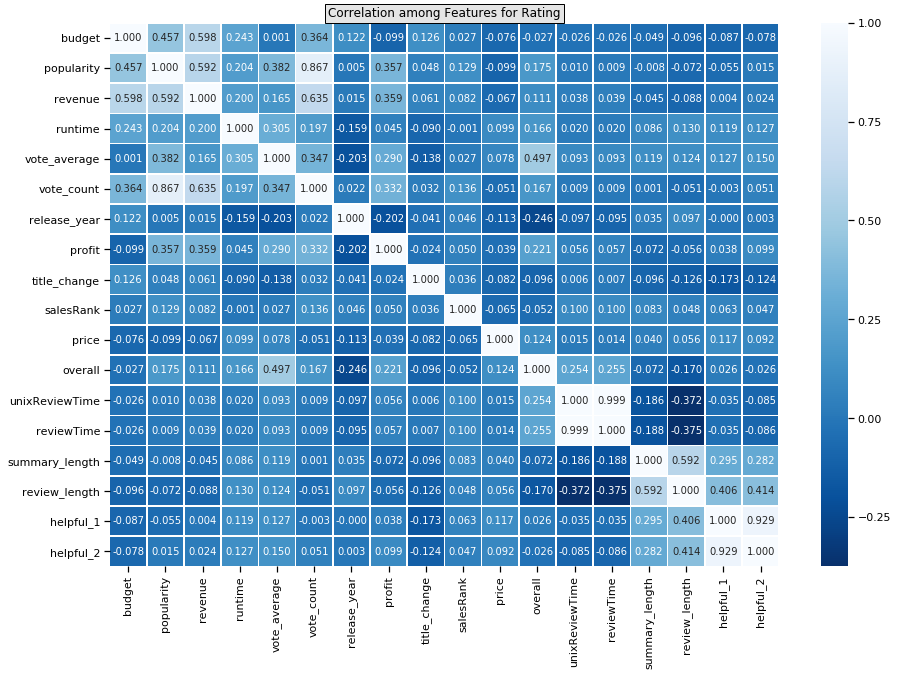

In [45]:
potential_type = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
merge_ml = merge_ml.select_dtypes(include=potential_type)
plt.figure(figsize=(15, 10))
sns.heatmap(merge_ml.corr(), annot = True, fmt = ".3f", linewidths = .5, cmap = 'Blues_r');
plt.title('Correlation among Features for Rating', fontsize=12, bbox={'facecolor':'1.9', 'pad':3})
plt.show()

Again, we take a glacne at the correlation among value features for rating.

In [46]:
temp_feature=['budget','revenue','profit','popularity','runtime','vote_average', 'vote_count','release_year','title_change','price',
             'reviewTime','review_length','summary_length','helpful_1','helpful_2']
temp_label=['overall']
merge_features = merge_ml[temp_feature]
merge_labels=merge_ml[temp_label]

We split the data into training set and testing set with a ratio of 80% and 20 %. Since we will do randomization in later cross validation process. Here we just take the first 80% of raw dataset to training set.In case of extraordinary features, we again use dropna.

In [47]:
merge_len=len(merge_features)
train_features= merge_features[:round( 0.8 * merge_len )]
test_features = merge_features[round( 0.8 * merge_len ):]
train_labels= merge_labels[:round( 0.8 * merge_len )]
test_labels= merge_labels[round( 0.8 * merge_len ):]

Then we do the normalization. We calculate the mean and std of each column of feature in training set and use the calculated result to realize the normalization in both training and testing datasets

In [48]:
for temp_col in merge_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std

In [49]:
train_features=train_features.dropna(how='all',axis=0)
train_features=train_features.fillna(0)
test_features=test_features.dropna(how='all',axis=0)
test_features=test_features.fillna(0)

We use support vector regressor (svr) to deal with the regression

In [50]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [68]:
gamma_range=np.logspace(-5,5,11)
c_range= np.logspace(-5,5,11)
gamma_score=pd.DataFrame({'gamma':gamma_range,'mse':0.0})
c_score=pd.DataFrame({'c':c_range,'mse':0.0})
svr_score= pd.merge(gamma_score, c_score)
svr_score= svr_score[['gamma','c','mse']]

For each potential combination of 2 parameters, we use support vector regressor with cross validation to get the mean square error of the chosen combination, and fill in the accuracy of the dataframe `svr_score` in corresponding row. The approach complies to the grid search. And after running all combinations, the output of `rfc_score` is as follows.

In [69]:
k_indices=build_k_indices(train_labels,5,10)
for i in range(len(svr_score)):
    score_sum=0
    temp_gamma= svr_score['gamma'].values[i]
    temp_c= svr_score['c'].values[i]
    for k in range(5):
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= train_features.values[temp_train_indice]
        temp_train_labels=train_labels.values[temp_train_indice]
        temp_valid_features=train_features.values[temp_valid_indice] 
        temp_valid_labels=train_labels.values[temp_valid_indice]
        
        temp_svr = SVR(kernel='rbf', C=temp_c, gamma=temp_gamma)
        temp_svr.fit(temp_train_features, temp_train_labels)
        temp_valid_pred = temp_svr.predict(temp_valid_features)
        temp_score=mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    temp_mse= score_sum/5
    svr_score['mse'].values[i]= temp_mse
svr_score.head()
        

,gamma,c,mse
0,0.00001,0.00001,0.311092
1,0.00001,0.00010,0.311091
2,0.00001,0.00100,0.311084
3,0.00001,0.01000,0.311020
4,0.00001,0.10000,0.310351


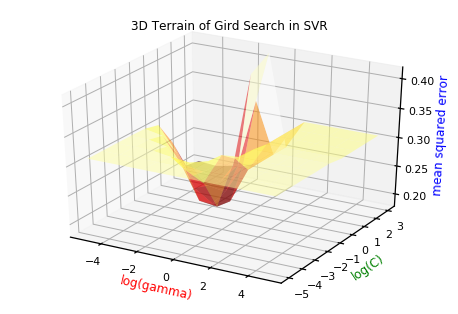

In [72]:
from mpl_toolkits.mplot3d import Axes3D
temp_fig=plt.figure()
temp_ax=Axes3D(temp_fig)
temp_x=np.array(range(-5,6))
temp_y=np.array(range(-5,4))
temp_x, temp_y = np.meshgrid(temp_x, temp_y)
temp_z=np.ones([9,11])
for i in range(len(temp_x)):
    for j in range(len(temp_x[0])):
        x=temp_x[0][j]
        y=temp_y[i][0]
        x=float(x)
        y=float(y)      
        temp_gamma=10**(x)
        temp_c=10**(y)
        temp_df=svr_score[svr_score['gamma']==temp_gamma] 
        temp_df=temp_df[temp_df['c']==temp_c]
        temp_mse=temp_df['mse'].values[0]
        temp_z[i][j]=temp_mse
temp_ax.plot_surface(temp_x, temp_y, temp_z, rstride = 1, cstride = 1, cmap=plt.cm.hot,alpha=0.5)
temp_ax.set_title('3D Terrain of Gird Search in SVR')
temp_ax.set_xlabel('log(gamma)', color='r')
temp_ax.set_ylabel('log(C)', color='g')
temp_ax.set_zlabel('mean squared error', color='b')
temp_fig.show()

get the 3D terrain figure for the 2 hyperparameters, with the height z set as the value of mse

Also, we use plotly to get an interactive 3D terrain surface figure for a more intuitvie obervatoin of grid search.

In [73]:
svr_score_log=svr_score.copy()
svr_score_log['gamma']=np.log10(svr_score_log['gamma'])
svr_score_log['c']=np.log10(svr_score_log['c'])

In [74]:
svr_3d=pd.DataFrame(columns=range(-5,6),index=range(-5,6))
for col in svr_3d.columns:
    for row in svr_3d.index:
        temp_gamma=col
        temp_c=row
        temp_values=svr_score_log[svr_score_log['gamma']==temp_gamma]
        temp_values=temp_values[temp_values.c==temp_c]
        temp_value=temp_values.mse.values[0]
        svr_3d[col][row]=temp_value

We turn the data strcture for the input of plotly 3D surface figure.

In [95]:
data = [go.Surface(z=svr_3d.as_matrix() )]
layout = go.Layout(
    #scene = list(xaxis = list(title = 'log10(gamma)+5'))
    xaxis=dict(title="log10(gamma)+5",autorange=False,range=[-5,5],type='linear', ),
    yaxis=dict(title='log10(C)+5' ,showgrid=False, ),
    title='3D Terrain of Gird Search in SVR (x:log10(gamma)+5, y:log10(C)+5)',
    autosize=False,
    width=600,height=600,
    margin=dict(l=65,r=50,b=65,t=90))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='3D Terrain of Gird Search in SVR')

The plotly figure is stored in '[plotly_image/3D Terrain of Gird Search in SVR.html](plotly_image/3D%20Terrain%20of%20Gird%20Search%20in%20SVR.html)' on github.

Upon that we can get the best hyperparameter for gamma and penalty C by a more interactive terrain surface.

In [76]:
svr_score_min=min(svr_score['mse'])
best_gamma= svr_score[svr_score['mse']==svr_score_min]['gamma'].values[0]
best_c= svr_score[svr_score['mse']==svr_score_min]['c'].values[0]
print('the best gamma for the model: '+str(best_gamma))
print('the best C for the model: '+str(best_c))

the best gamma for the model: 0.01
the best C for the model: 1.0


We define function to get the mse metric of selected features training compared with true labels with the method of training support vector regressor with 5-cross-validation.

In [77]:
def svr_mse_cv5(features,labels):
    score_sum=0
    k_indices=build_k_indices(labels,5,10)
    for k in range(5):       
        temp_valid_indice = k_indices[k]
        temp_train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
        temp_train_indice = temp_train_indice.reshape(-1)
        temp_train_features= features.values[temp_train_indice]
        temp_train_labels=labels.values[temp_train_indice]
        temp_valid_features=features.values[temp_valid_indice] 
        temp_valid_labels=labels.values[temp_valid_indice]  
        temp_model =  SVR(kernel='rbf', C=best_c, gamma=best_gamma)
        temp_model.fit(temp_train_features,temp_train_labels)
        temp_valid_pred = temp_model.predict(temp_valid_features)                
        temp_score = mean_squared_error(temp_valid_labels, temp_valid_pred) 
        score_sum=score_sum+temp_score
    return score_sum/5

Then we use greedy selection to iteratively select features one by one. Our code creates a dataframe `features_select` with each potential value feature in each row and its corresponding mse, which is initialized as 0.0. A list `select_feature` is also defined and initialized empty. Our code use the `select_feature` to restore the selected features in each iteration. From the iterations, we choose each of the features remained in the dataframe, and combine the temporary single feature with the selected feature in the `select_feature` to form a combination of `temp_train_feature`. After fitting them with training labels by support vector regressor, we can get the mse (chosen as main metric) of each remained single feature combined with the features already moved in `select_feature`. Our code sort the dataframe by mse value on ascending order. Then we can select the one feature with the smallest accuracy value, which is to say, that feature contributing most to the prediction combined with features already selected. And the dataframe updates itself by deleting the first row (corresponding to the feature decided to be selected in this iteration). That feature is also added to `select_feature` to the next iteration. The iteration is not over until the dataframe `features_select` has the last one feature. The code approach complies to defination of greedy selection to select features one by one. 

In [78]:
features_select = pd.DataFrame({'feature':np.array(train_features.columns),'mse':0.0})
temp_features_select=features_select.copy()
select_feature=[]
select_score=[]
while len(temp_features_select)>0:
    for i in range(len(temp_features_select)):
        temp_feature=temp_features_select['feature'].values[i]
        temp_train_feature=select_feature+ [temp_feature]
        temp_score=svr_mse_cv5(train_features[temp_train_feature],train_labels)
        temp_features_select['mse'].values[i]= temp_score
    temp_features_select=temp_features_select[['feature','mse']].sort_values(ascending=True, by='mse')
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
    temp_select_feature=temp_features_select['feature'].values[0]
    temp_select_score=temp_features_select['mse'].values[0]
    k=len(temp_features_select)
    features_select['feature'].values[15-k]= temp_select_feature
    select_feature=select_feature + [temp_select_feature]
    select_score=select_score+[temp_select_score]
    temp_features_select=temp_features_select[1:]
    temp_features_select.reset_index(inplace=True)
    temp_features_select=temp_features_select[['feature','mse']]
select_feature

['vote_average',
 'review_length',
 'release_year',
 'reviewTime',
 'title_change',
 'summary_length',
 'price',
 'budget',
 'runtime',
 'helpful_2',
 'helpful_1',
 'revenue',
 'profit',
 'vote_count',
 'popularity']

Here we get the order of value feature that affect the movie ratings.

In [79]:
test_features_score = pd.DataFrame({'feature_number':range(1,16) , 'test_mse':0.0,'cross_validation_mse' :np.array(select_score) })
k=0
for i in range(1,16):
    temp_train_features = select_feature[:i+1]
    temp_model =  SVR(kernel='rbf', C=best_c, gamma=best_gamma)
    temp_model.fit(train_features[temp_train_features], train_labels)
    temp_test_pred = temp_model.predict(test_features[temp_train_features])
    temp_score = mean_squared_error(temp_test_pred, test_labels) 
    test_features_score['test_mse'][k] = temp_score
    k=k+1

To verify the most important features, we use a line plot to get an intuitive visualization of the performance of selected features in cross validatoin and test set.

In [80]:
mse_list=['cross_validation_mse','test_mse']
potantial_color=['#b3cde3','#fbb4ae']
temp_line=[]
for ind, mse in enumerate(mse_list):
    temp_line.append(
        go.Scatter(
            x=test_features_score.feature_number,
            y=test_features_score[mse],
            name=mse,legendgroup=mse,
            line = dict(color = (potantial_color[ind]),width = 3),), )
layout = go.Layout( autosize=True, title='CV MSE vs Test MSE',)
fig = go.Figure(data=temp_line,layout=layout)

py.iplot(fig,filename='CV MSE vs Test MSE')

The plotly figure is stored in '[plotly_image/CV MSE vs Test MSE.html](plotly_image/CV%20MSE%20vs%20Test%20MSE.html)' on github.

The performance with different number of feature selected have a similar trend in validation set and test set. The curve flattens after feature number at 6 and then falls at around 10. The most obvious fall happen in the first several numbers, which is to say that the first 6 value features could predict the average rating with acceptable mean square value.

To verify our assumption, we select the top 6 features and again train in cross validation and test in testing set by support vector model with chosen grid searched hyperparameters.

In [83]:
features=['vote_average','review_length','release_year', 'reviewTime', 'title_change','summary_length']
merge_features=merge_ml[features]
merge_labels=merge_ml['overall']
merge_len=len(merge_features)
train_features= merge_features[:round( 0.8 * merge_len )]
test_features = merge_features[round( 0.8 * merge_len ):]
train_labels= merge_labels[:round( 0.8 * merge_len )]
test_labels= merge_labels[round( 0.8 * merge_len ):]
for temp_col in merge_features.columns:
    temp_mean=train_features[temp_col].mean()
    temp_std=train_features[temp_col].std()
    train_features[temp_col]=(train_features[temp_col]-temp_mean)/temp_std
    test_features[temp_col]=(test_features[temp_col]-temp_mean)/temp_std

In [84]:
temp_model =  SVR(kernel='rbf', C=best_c, gamma=best_gamma)
temp_model.fit(train_features,train_labels)
temp_pred = temp_model.predict(test_features)

In [88]:
test_predict_array=temp_model.predict(merge_features)
test_labels_array=np.array(merge_labels)
merge_pred_label=pd.DataFrame({'ground_truth':test_labels_array,'prediction':test_predict_array,'count':range(len(merge_labels))})

In [89]:
label_list=['ground_truth','prediction']
potantial_color=['#b3cde3','#fbb4ae']
temp_line=[]
for ind, label in enumerate(label_list):
    temp_line.append(
        go.Scatter(
            x=merge_pred_label['count'],
            y=merge_pred_label[label],
            name=label,legendgroup=label,
            line = dict(color = (potantial_color[ind]),width = 1),), )
layout = go.Layout( autosize=True, title='Ground Truth vs Prediction in Test Set',)
fig = go.Figure(data=temp_line,layout=layout)
#temp_line.layout['legend']=dict( orientation="h", y=1.2,font=dict(size=7, ),)

py.iplot(fig, filename='ground_truth_vs_prediction')

The plotly figure is stored in '[plotly_image/ground_truth_vs_prediction.html](plotly_image/ground_truth_vs_prediction.html)' on github.

We get the curve of ground_truth label and prediction in plt and plotly. We can also observe that the main trend of the curves are similar, and the average difference between each testing data point is not far, which is to say our model with 6 selected features have an acceptable performance. Since our aim is not to make a perfect machine learning model, but to find the top features that affect rating most, the selected features through support vector regressor can comply to our goal.

For further proof of assumption,we get the cumulative value in the dataset and choose the first 50 for better observation of prediction performance. Also a kde figure is plotted.

In [91]:
merge_pred_label['ground_truth_sum']=0.0
merge_pred_label['prediction_sum']=0.0
sum_gt=0.0
sum_pred=0.0
for i in range(len(merge_pred_label)):
    sum_gt=sum_gt+merge_pred_label.ground_truth.values[i]
    merge_pred_label['ground_truth_sum'][i]=sum_gt
    sum_pred=sum_pred+merge_pred_label.prediction.values[i]
    merge_pred_label['prediction_sum'][i]=sum_pred

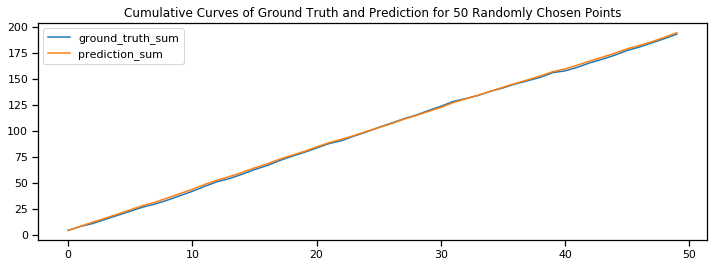

In [92]:
show_pred_label=merge_pred_label.iloc[:50]
plt.figure(figsize=(12,4))
plt.plot( show_pred_label['count'],show_pred_label['ground_truth_sum'])
plt.legend()
plt.plot( show_pred_label['count'],show_pred_label['prediction_sum'])
plt.title('Cumulative Curves of Ground Truth and Prediction for 50 Randomly Chosen Points')
plt.legend()

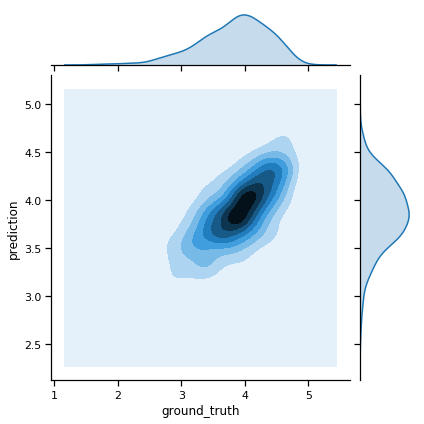

In [98]:
sns.jointplot(x='ground_truth',y='prediction',title='KDE Plot for Ground Truth and Prediction',
              data=merge_pred_label,kind='kde')
plt.show()

From the observation, although there exist some outliers and difference between ground truth labels and model predictions, most predcitions conform to the same trend with the labels, for example, the 2 line plots almost overlap despite some little distance between the lines.
We admit our machine learning model is not perfect and have a large space for improvement, but we have realizaed our target to choose the top features related to Amazon average rating.

So far we have used the called 'black box' machine learning model to get the top value features that affect the ratingss. Later we will go a bit further in analysis of relationship between single feature with the ratings.

Maps are also used to visualize the relationship between vote and rating among countries. First, we get the average rate of all the movies in each potential country in the dataset.

In [24]:
va_array=[]
for temp_country in country_count.index:
    temp_count=0
    va_sum=0
    for i in range(len(merge_geo)):
        if temp_country in merge_geo['production_countries'].values[i]:
            va_sum=va_sum+merge_geo.vote_average.values[i]
            temp_count=temp_count+1
    temp_country_va=va_sum/temp_count
    va_array=va_array+[temp_country_va]

We introduce a proportion temp_pop to represent a linear relationship between average vote and average rating since the maxium values of vote and rating are not identical. We use the proportion to make both values share the same range.

In [39]:
country_va=pd.DataFrame({'Country':np.array(country_count.index), 'vote_average':np.array(va_array)})
country_rating_va=pd.merge(country_ratings,country_va,on='Country')
temp_prop=max(merge_geo['vote_average'])/max(merge_geo['overall'])
country_rating_va['V/R']=(country_rating_va['vote_average']-country_rating_va['overall_rating']*temp_prop)/(country_rating_va['overall_rating']*temp_prop)
country_rating_va.tail(2)

,Country,comedy_rating,overall_rating,vote_average,V/R
43,United Kingdom,4.074607,4.018485,6.655361,-0.025773
44,United States of America,3.918996,3.939228,6.458872,-0.035512


Instead of visualizing the value of pure vote, we use change trend of vote against rating by division, which can show the interconnenction between 2 values and use the folium to plot a map. We use the value of (vote-rating)/rating to represent for the distribution.

In [68]:
geo_border = json.load(open('countries_borders.geo.json'))
m_vr = folium.Map([ 0, 0], zoom_start=2)
m_vr.choropleth(geo_data=geo_border, data=country_rating_va,
             columns=['Country', 'V/R'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Vote Average vs Rating')
folium.TopoJson(
    geo_border,
    'feature.properties.name',
    style_function=nan_handle_function,
    control=False
).add_to(m_vr)
m_vr.save('images/Vote_Average_vs_Rating.html')
display(m_vr)

The map is stored in '[maps/Vote_Average_vs_Rating.html](maps/Vote_Average_vs_Rating.html)' on github.

Except in some areas in Africa, most countries have the 2 lightest colors among the threshold, and the value is around 0.Therefore, the value of vote does have a strong relationship with Amazon ratings, and can been seen as a linear relationship, although it's not strictly linear by some bias from the accurate 0.

Now we use another intuitive graph to visualize the relationship, focusing on the average rating and average vote of 20 countries that produce most movies.

In [58]:
country_line=country_rating_va[['Country','overall_rating','vote_average']].sort_values(by='overall_rating',ascending=False)
country_line=country_line.iloc[:20]
country_line['vote_average']=country_line['vote_average']/temp_prop
country_line = country_line.groupby('Country').mean()

In [59]:
country_line = country_line.loc[:,["overall_rating","vote_average"]]
country_line = country_line.stack()
country_line = country_line.to_frame()
country_line.reset_index(inplace=True)
country_line.columns = country_line.columns.astype(str)
country_line.rename(columns={"level_1":"type","0":"value"},inplace=True)

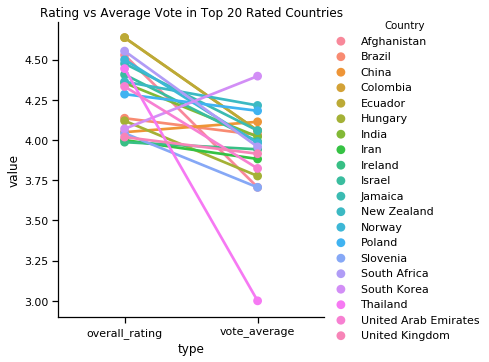

In [60]:
sns.catplot(x="type", y="value",hue="Country", kind="point", data=country_line)
plt.title("Rating vs Average Vote in Top 20 Rated Countries")
plt.show()

Most lines in the graph are parallell to each other, proving to having a not strictly linear relationship. Nearly all countries have a lower value in average vote after dividing it by the proportion. It turns out compard to Amazon rating, TMDB vote is a bit more strict. The phenomena conform to our representation in the vote geographic distribution above.

# References on the Amazon dataset

- R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
- J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015